In [36]:
# Introduction

# This notebook aims to predict ICU mortality using the GOSSIS dataset.
# The goal is to build a machine learning model that generalizes across diverse healthcare settings,
# providing clinicians with actionable insights to improve patient care globally.




In [37]:


# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import random
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
data = pd.read_csv('dataset.csv')

# Drop unnecessary columns
cols_to_drop = ['encounter_id', 'patient_id', 'hospital_id', 'icu_id', 'Unnamed: 83']
data.drop(columns=cols_to_drop, inplace=True)

# Save 'apache_4a_hospital_death_prob' and 'apache_4a_icu_death_prob' in a separate DataFrame
apache_probs = data[['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob']].copy()

# Drop these columns from the main dataset
data.drop(columns=['apache_4a_hospital_death_prob', 'apache_4a_icu_death_prob'], inplace=True)

# Display confirmation of saved and deleted columns
print("Saved apache columns in a separate DataFrame and removed them from the main dataset.")
print("Apache Probabilities DataFrame:")
print(apache_probs.head())


# Replace the lowercase value with the uppercase value to combine these categories
data['apache_2_bodysystem'] = data['apache_2_bodysystem'].replace('Undefined diagnoses', 'Undefined Diagnoses')

# Verify that the categories have been combined
print("Value Counts for 'apache_2_bodysystem' after combining categories:")
print(data['apache_2_bodysystem'].value_counts())
# Convert binary variables to categorical
binary_categorical_vars = [
    'intubated_apache', 'ventilated_apache', 'aids', 'cirrhosis',
    'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
    'leukemia', 'lymphoma', 'solid_tumor_with_metastasis',
    'apache_post_operative', 'arf_apache', 'gcs_unable_apache', 'elective_surgery'
]
for col in binary_categorical_vars:
    data[col] = data[col].astype('category')

# Convert target variable to integer if it's not already
data['hospital_death'] = data['hospital_death'].astype(int)

categorical_vars = ['icu_admit_source', 'ethnicity', 'gender', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 'icu_stay_type']
data = pd.get_dummies(data, columns=categorical_vars, drop_first=True)



Saved apache columns in a separate DataFrame and removed them from the main dataset.
Apache Probabilities DataFrame:
   apache_4a_hospital_death_prob  apache_4a_icu_death_prob
0                           0.10                      0.05
1                           0.47                      0.29
2                           0.00                      0.00
3                           0.04                      0.03
4                            NaN                       NaN
Value Counts for 'apache_2_bodysystem' after combining categories:
apache_2_bodysystem
Cardiovascular         38816
Neurologic             11896
Respiratory            11609
Gastrointestinal        9026
Metabolic               7650
Undefined Diagnoses     4114
Trauma                  3842
Renal/Genitourinary     2460
Haematologic             638
Name: count, dtype: int64


In [38]:
# Set display options to show all rows for missing values
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns (if needed)

# Calculate and display missing values in each column
missing_values = data.isnull().sum()
missing_values = missing_values[missing_values > 0]

print("Missing Values in Each Column:")
print(missing_values)

# Reset display options back to default if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

Missing Values in Each Column:
age                            4228
bmi                            3429
height                         1334
weight                         2720
apache_2_diagnosis             1662
apache_3j_diagnosis            1101
arf_apache                      715
gcs_eyes_apache                1901
gcs_motor_apache               1901
gcs_unable_apache              1037
gcs_verbal_apache              1901
heart_rate_apache               878
intubated_apache                715
map_apache                      994
resprate_apache                1234
temp_apache                    4108
ventilated_apache               715
d1_diasbp_max                   165
d1_diasbp_min                   165
d1_diasbp_noninvasive_max      1040
d1_diasbp_noninvasive_min      1040
d1_heartrate_max                145
d1_heartrate_min                145
d1_mbp_max                      220
d1_mbp_min                      220
d1_mbp_noninvasive_max         1479
d1_mbp_noninvasive_min         14

In [39]:
# Update lists of numerical and categorical features
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')

In [40]:
# Handling Missing Values

# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# Display the percentage distribution of hospital deaths
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)

# For now, drop any rows that have missing values
data = data.dropna()

# Alternative strategies:
# - Impute numerical features using mean, median, or mode
# - Use KNN imputation or regression models to estimate missing values
# - Impute categorical features with the most frequent category or 'Unknown'
# - Use advanced imputation techniques like MICE (Multiple Imputation by Chained Equations)


# Calculate the value counts for 'hospital_death' and convert them to percentages
hospital_death_counts = data['hospital_death'].value_counts(normalize=True) * 100

# Display the percentage distribution of hospital deaths
print("Percentage Distribution of Hospital Deaths:")
print(hospital_death_counts)


Percentage Distribution of Hospital Deaths:
hospital_death
0    91.369817
1     8.630183
Name: proportion, dtype: float64
Percentage Distribution of Hospital Deaths:
hospital_death
0    91.587413
1     8.412587
Name: proportion, dtype: float64


### PCA Exploration

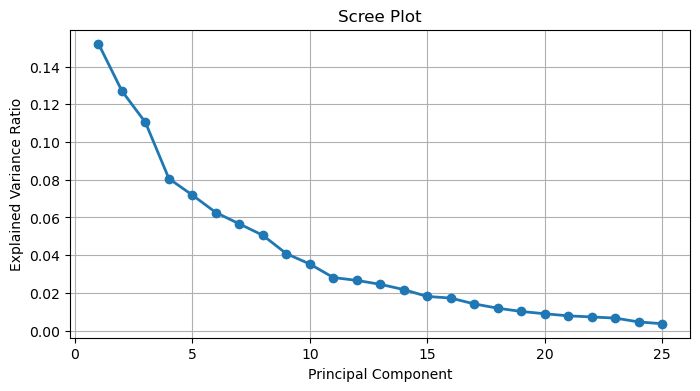

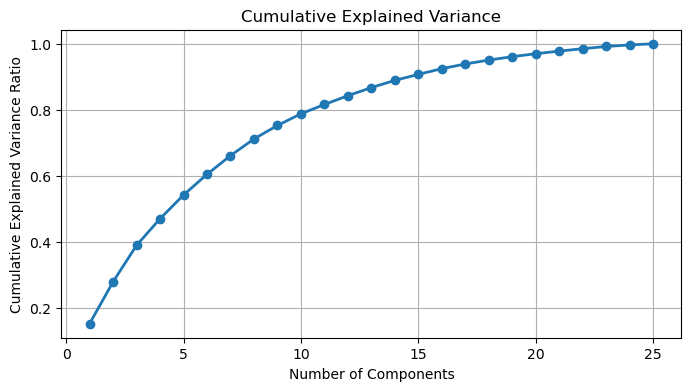

PCA Components for Physiological Data:


heart_rate_apache  d1_heartrate_max  d1_heartrate_min  map_apache  \
0           -0.080738         -0.123659         -0.007168    0.301492   
1            0.271930          0.313489          0.116327    0.231410   
2            0.376884          0.329683          0.397264   -0.090343   
3           -0.002799          0.073116         -0.124474    0.047453   
4           -0.125997         -0.074009         -0.173576   -0.015112   
5           -0.055509         -0.075441          0.026270    0.022972   
6           -0.274790         -0.251520         -0.245807    0.001395   
7           -0.215733         -0.187336         -0.192579   -0.034519   
8           -0.025286         -0.015714         -0.006277   -0.015394   
9           -0.054189         -0.094129          0.113171    0.006457   
10           0.073818          0.075075         -0.002983   -0.023604   
11           0.070852          0.055862         -0.033170   -0.042557   
12          -0.000864          0.028828         -0.119374    0.126611   
13           0.024183         -0.053133          0.010662    0.893270   
14           0.220543          0.211219         -0.191392    0.046900   
15          -0.269627         -0.325682          0.775513    0.036341   
16           0.051293         -0.106154          0.085494   -0.119167   
17          -0.013626          0.002241          0.038687    0.033311   
18          -0.058648          0.006171          0.036922   -0.038174   
19           0.109682         -0.053796         -0.058048    0.011401   
20          -0.031587          0.042029          0.007482    0.008212   
21           0.012710         -0.017380         -0.000805   -0.008387   
22           0.693290         -0.686606         -0.068359   -0.039309   
23          -0.018516          0.051828          0.003936   -0.066717   
24           0.008440         -0.016778          0.011074    0.005352   

    d1_mbp_max  d1_mbp_min  d1_sysbp_max  d1_sysbp_min  d1_diasbp_max  \
0     0.281747    0.418437      0.270500      0.408509       0.208840   
1     0.346523    0.006495      0.285011     -0.029617       0.332388   
2    -0.124983    0.005951     -0.154229     -0.026410      -0.107485   
3     0.251446   -0.266957      0.204308     -0.218276       0.276271   
4     0.115536   -0.150599      0.126435     -0.088258       0.161780   
5    -0.031923    0.071024      0.043907      0.115405      -0.034496   
6    -0.011910    0.029709     -0.005744      0.003399      -0.108316   
7    -0.006868   -0.083745      0.088960     -0.011676      -0.059399   
8    -0.036011    0.058411     -0.000575      0.038662      -0.089708   
9     0.155541   -0.248129      0.121948     -0.135166       0.210781   
10    0.054816   -0.046914     -0.053676     -0.128247       0.045687   
11   -0.002448    0.008500     -0.087761     -0.040173       0.070395   
12   -0.054286    0.001522      0.029253      0.032302      -0.069817   
13   -0.122475   -0.103245     -0.234866     -0.181452      -0.187382   
14   -0.170496   -0.060683      0.553511      0.389598      -0.448064   
15    0.000802   -0.084271      0.201550      0.127014      -0.081939   
16    0.094171    0.006049      0.059458     -0.014633      -0.023398   
17    0.002928   -0.015060     -0.013303      0.032825      -0.005974   
18    0.006252    0.002787      0.056570     -0.010520      -0.017043   
19    0.000193   -0.064683     -0.486105      0.644254       0.353670   
20    0.002462   -0.006374     -0.046608      0.076527       0.016659   
21    0.021005   -0.004256     -0.033542      0.036175       0.011048   
22    0.057817   -0.006764      0.058449     -0.093185      -0.033675   
23    0.696642    0.353174     -0.253458     -0.091042      -0.450360   
24   -0.365520    0.707076      0.107591     -0.286932       0.279477   

    d1_diasbp_min  ...  d1_temp_min  d1_spo2_max  d1_spo2_min  d1_glucose_max  \
0        0.379802  ...     0.129618    -0.105561     0.124611       -0.043879   
1        0.014482  ...    -0.099253     0.08

In [41]:
# List of physiological variables
physiological_vars = [
    'heart_rate_apache', 'd1_heartrate_max', 'd1_heartrate_min',
    'map_apache', 'd1_mbp_max', 'd1_mbp_min',
    'd1_sysbp_max', 'd1_sysbp_min',
    'd1_diasbp_max', 'd1_diasbp_min',
    'resprate_apache', 'd1_resprate_max', 'd1_resprate_min',
    'temp_apache', 'd1_temp_max', 'd1_temp_min',
    'd1_spo2_max', 'd1_spo2_min',
    'd1_glucose_max', 'd1_glucose_min',
    'd1_potassium_max', 'd1_potassium_min',
    'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache'
]

# Ensure all variables are in the dataset
physiological_vars = [var for var in physiological_vars if var in data.columns]

# Extract the physiological data
physio_data = data[physiological_vars]
physio_data = physio_data.dropna()



# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the data
physio_data_scaled = scaler.fit_transform(physio_data)


# Initialize PCA
pca = PCA()

# Fit PCA on the scaled data
pca.fit(physio_data_scaled)

# Transform the data
physio_pca = pca.transform(physio_data_scaled)

# Calculate explained variance ratios
explained_variance = pca.explained_variance_ratio_

# Generate scree plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Plot cumulative explained variance
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Get PCA components for physiological data
physio_components = pd.DataFrame(pca.components_, columns=physio_data.columns)
print("PCA Components for Physiological Data:")
display(physio_components)

Data retained after dropping missing values: 100.00%


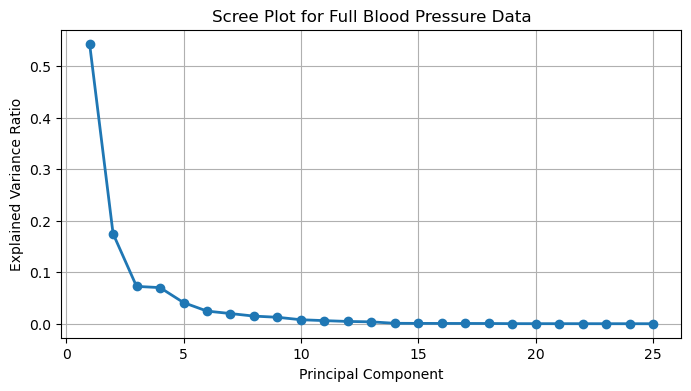

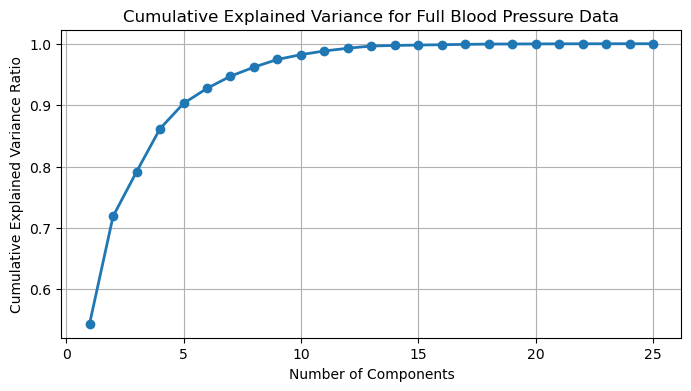

PCA Components for Full Blood Pressure Data:


map_apache  d1_mbp_max  d1_mbp_min  d1_mbp_noninvasive_max  \
0     0.161879    0.192013    0.186400                0.191961   
1     0.050736    0.256917   -0.283387                0.256236   
2     0.127944    0.102239    0.095098                0.103286   
3    -0.195368   -0.232302   -0.210476               -0.232376   
4     0.042831    0.124438   -0.130988                0.125240   
5     0.872009    0.014172    0.005408                0.014037   
6    -0.284081    0.055286    0.084270                0.056224   
7    -0.269744    0.352466    0.178866                0.356119   
8     0.019319    0.025566    0.025455                0.023658   
9     0.017442   -0.270174    0.444592               -0.267308   
10   -0.003075   -0.066947    0.029859               -0.072289   
11    0.015217   -0.181898   -0.282474               -0.187859   
12    0.007450   -0.274764    0.020675               -0.278260   
13   -0.000197   -0.032676   -0.007556                0.041077   
14    0.001258   -0.179448    0.022908                0.183483   
15   -0.001089    0.652314   -0.065563               -0.646922   
16    0.002526    0.143130   -0.011817               -0.143152   
17    0.000948    0.016948    0.015135               -0.017471   
18    0.000370   -0.076934   -0.515318                0.073210   
19    0.000272    0.045979    0.013640               -0.046023   
20    0.000022    0.002583    0.010009               -0.007092   
21   -0.000835    0.113520   -0.103398               -0.111204   
22   -0.000002   -0.048215   -0.462599                0.047219   
23    0.000045    0.014583   -0.008334               -0.014868   
24    0.000214    0.000941    0.007453               -0.000892   

    d1_mbp_noninvasive_min  h1_mbp_max  h1_mbp_min  h1_mbp_noninvasive_max  \
0                 0.186506    0.232522    0.234675                0.232694   
1                -0.284026    0.109005   -0.116534                0.107995   
2                 0.094836   -0.169996   -0.136594               -0.169895   
3                -0.210316    0.098380    0.135795                0.097278   
4                -0.130422   -0.271139    0.254202               -0.270844   
5                 0.004746    0.103941    0.082324                0.101183   
6                 0.083005    0.006872    0.071337                0.010787   
7                 0.177200    0.291852    0.215406                0.291922   
8                 0.023834   -0.025046   -0.056091               -0.025980   
9                 0.436263   -0.135412    0.193671               -0.132735   
10                0.029844    0.079060   -0.046249                0.081187   
11               -0.282376    0.058743    0.446527                0.055336   
12                0.019204    0.438649   -0.176435                0.451477   
13                0.002671   -0.244685   -0.129986                0.232454   
14               -0.024894   -0.304013    0.009232                0.301705   
15                0.071010   -0.005291   -0.003520                0.000632   
16                0.010319   -0.399292   -0.094010                0.402177   
17               -0.017657   -0.396771    0.034980                0.392852   
18                0.518223    0.013462   -0.135061               -0.011087   
19               -0.013652    0.163424    0.030663               -0.160081   
20               -0.009523    0.079049   -0.654790               -0.077482   
21                0.105049   -0.047927    0.084871                0.045229   
22                0.466930   -0.014145    0.125524                0.013143   
23                0.008823    0.000436    0.001106               -0.000615   
24               -0.007176    0.005760   -0.010340               -0.006728   

    h1_mbp_noninvasive_min  d1_sysbp_max  ...  h1_sysbp_noninvasive_max  \
0                 0.234762      0.186954  ...                  0.219289   
1                -0.117058      0.211782  ...                  0.108902   
2                -0.136515      0

In [42]:
# List of all blood pressure variables, excluding 'mean' columns
bp_vars_full = [
    'map_apache',
    'd1_mbp_max', 'd1_mbp_min',
    'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
    'h1_mbp_max', 'h1_mbp_min',
    'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
    'd1_sysbp_max', 'd1_sysbp_min',
    'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
    'h1_sysbp_max', 'h1_sysbp_min',
    'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
    'd1_diasbp_max', 'd1_diasbp_min',
    'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
    'h1_diasbp_max', 'h1_diasbp_min',
    'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min'
]
# Ensure variables are in the dataset
bp_vars_full = [var for var in bp_vars_full if var in data.columns]
# Extract blood pressure data
bp_data_full = data[bp_vars_full]
# Drop rows with missing values
bp_data_full_clean = bp_data_full.dropna()

# Print the percentage of data retained
data_retained = len(bp_data_full_clean) / len(bp_data_full) * 100
print(f"Data retained after dropping missing values: {data_retained:.2f}%")

scaler = StandardScaler()
bp_data_scaled = scaler.fit_transform(bp_data_full_clean)

pca_bp_full = PCA()
pca_bp_full.fit(bp_data_scaled)
bp_pca_full = pca_bp_full.transform(bp_data_scaled)

explained_variance_bp_full = pca_bp_full.explained_variance_ratio_

# Scree Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_bp_full) + 1), explained_variance_bp_full, 'o-', linewidth=2)
plt.title('Scree Plot for Full Blood Pressure Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative Explained Variance
cumulative_explained_variance_bp_full = np.cumsum(explained_variance_bp_full)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_bp_full) + 1), cumulative_explained_variance_bp_full, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Full Blood Pressure Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()
# PCA Components (Loadings)
bp_components_full = pd.DataFrame(pca_bp_full.components_, columns=bp_data_full_clean.columns)
print("PCA Components for Full Blood Pressure Data:")
display(bp_components_full)


In [43]:
# Blood Pressure Variables to Drop
bp_vars_to_drop = [
    # Non-Invasive Measurements
    'd1_mbp_noninvasive_max', 'd1_mbp_noninvasive_min',
    'h1_mbp_noninvasive_max', 'h1_mbp_noninvasive_min',
    'd1_sysbp_noninvasive_max', 'd1_sysbp_noninvasive_min',
    'h1_sysbp_noninvasive_max', 'h1_sysbp_noninvasive_min',
    'd1_diasbp_noninvasive_max', 'd1_diasbp_noninvasive_min',
    'h1_diasbp_noninvasive_max', 'h1_diasbp_noninvasive_min',
    # Hour 1 Measurements (if choosing to drop)
    'h1_mbp_max', 'h1_mbp_min',
    'h1_sysbp_max', 'h1_sysbp_min',
    'h1_diasbp_max', 'h1_diasbp_min'
]

# Drop the variables from the dataset
data.drop(columns=bp_vars_to_drop, inplace=True)

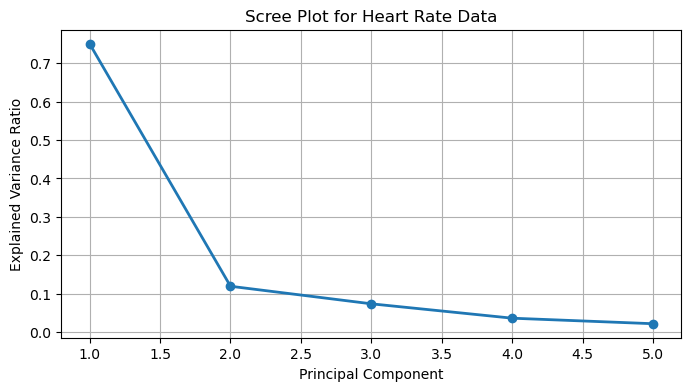

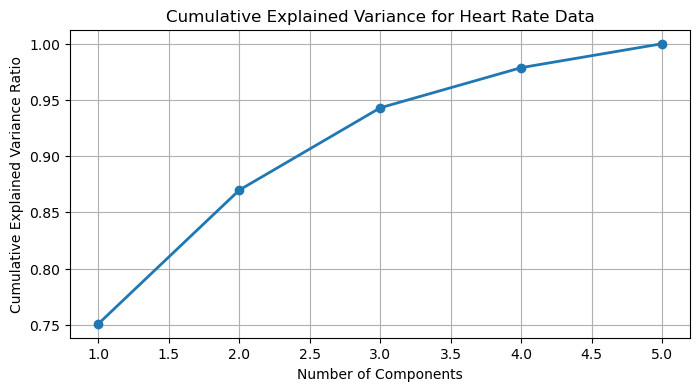

PCA Components for Heart Rate Data:


heart_rate_apache  d1_heartrate_max  d1_heartrate_min  h1_heartrate_max  \
0           0.454793          0.451139          0.385208          0.471517   
1          -0.244094         -0.470842          0.809451         -0.164670   
2           0.559433          0.233008          0.321372         -0.513295   
3          -0.631401          0.631624          0.278530          0.110203   
4           0.148150         -0.348626          0.124679          0.689158   

   h1_heartrate_min  
0          0.467893  
1          0.190782  
2         -0.515743  
3         -0.335649  
4         -0.605002

In [44]:
# PCA on Heart Rate Variables

# List of heart rate variables
hr_vars = [
    'heart_rate_apache', 'd1_heartrate_max', 'd1_heartrate_min',
    'h1_heartrate_max', 'h1_heartrate_min'
]

# Ensure variables are in the dataset
hr_vars = [var for var in hr_vars if var in data.columns]

# Extract heart rate data
hr_data = data[hr_vars]

# Handle missing values
hr_data = hr_data.dropna()

# Standardize the data
scaler = StandardScaler()
hr_data_scaled = scaler.fit_transform(hr_data)

# Perform PCA

pca_hr = PCA()
pca_hr.fit(hr_data_scaled)
hr_pca = pca_hr.transform(hr_data_scaled)



explained_variance_hr = pca_hr.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_hr) + 1), explained_variance_hr, 'o-', linewidth=2)
plt.title('Scree Plot for Heart Rate Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_hr = np.cumsum(explained_variance_hr)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_hr) + 1), cumulative_explained_variance_hr, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Heart Rate Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
hr_components = pd.DataFrame(pca_hr.components_, columns=hr_data.columns)
print("PCA Components for Heart Rate Data:")
display(hr_components)


In [45]:
# Heart Rate Variables to Drop
hr_vars_to_drop = ['h1_heartrate_max', 'h1_heartrate_min']

# Drop the variables from the dataset
data.drop(columns=hr_vars_to_drop, inplace=True)

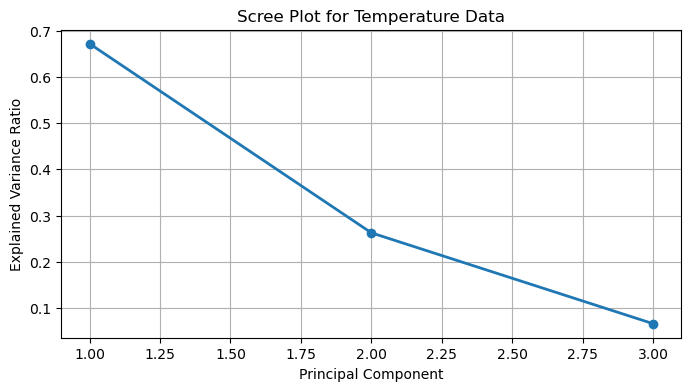

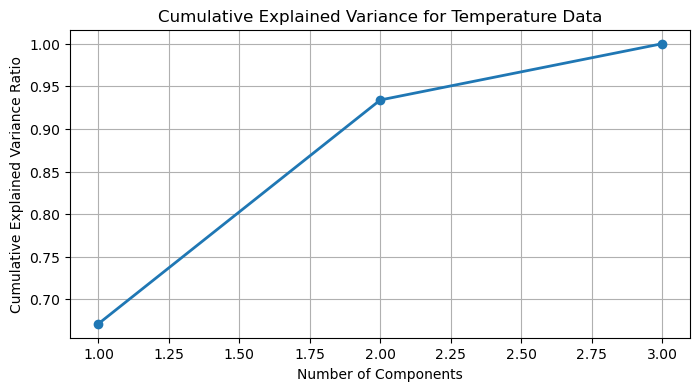

PCA Components for Temperature Data:


temp_apache  d1_temp_max  d1_temp_min
0     0.656017     0.430851     0.619685
1    -0.185503     0.887908    -0.420961
2     0.731594    -0.161204    -0.662407

In [46]:
# PCA on Temperature Variables

# List of temperature variables
temp_vars = [
    'temp_apache', 'd1_temp_max', 'd1_temp_min',
    'h1_temp_max', 'h1_temp_min'
]

# Ensure variables are in the dataset
temp_vars = [var for var in temp_vars if var in data.columns]

# Extract temperature data
temp_data = data[temp_vars]

# Handle missing values
temp_data = temp_data.dropna()

# Standardize the data
scaler = StandardScaler()
temp_data_scaled = scaler.fit_transform(temp_data)

# Perform PCA
pca_temp = PCA()
pca_temp.fit(temp_data_scaled)
temp_pca = pca_temp.transform(temp_data_scaled)

# Generate Scree Plot
explained_variance_temp = pca_temp.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_temp) + 1), explained_variance_temp, 'o-', linewidth=2)
plt.title('Scree Plot for Temperature Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_temp = np.cumsum(explained_variance_temp)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_temp) + 1), cumulative_explained_variance_temp, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Temperature Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
temp_components = pd.DataFrame(pca_temp.components_, columns=temp_data.columns)
print("PCA Components for Temperature Data:")
display(temp_components)


In [47]:
# Not really much to drop!

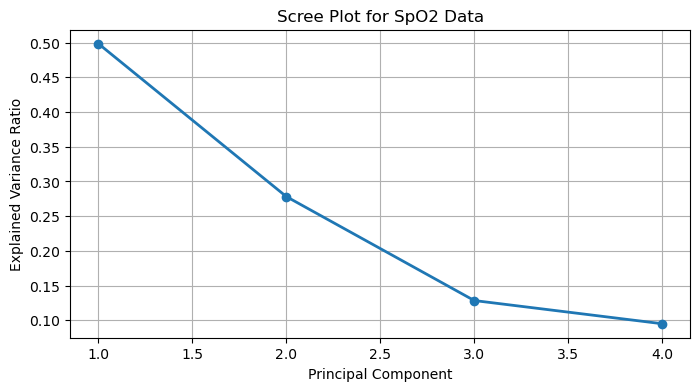

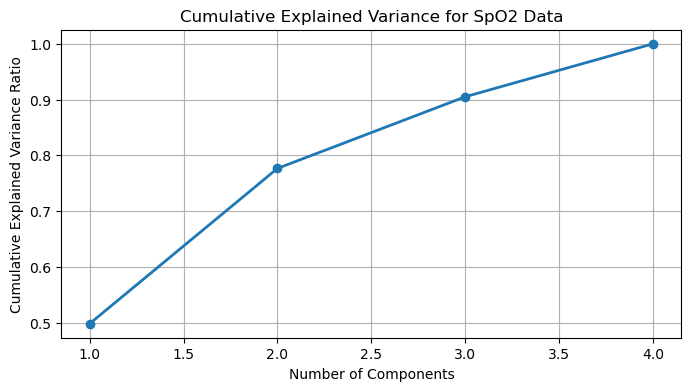

PCA Components for SpO2 Data:


d1_spo2_max  d1_spo2_min  h1_spo2_max  h1_spo2_min
0     0.402531     0.452566     0.552318     0.572798
1     0.651195    -0.589801     0.347946    -0.327129
2     0.598309     0.508977    -0.540442    -0.301482
3     0.236516    -0.433891    -0.530850     0.688475

In [48]:
# PCA on Peripheral Oxygen Saturation Variables

# List of SpO2 variables
spo2_vars = [
    'd1_spo2_max', 'd1_spo2_min',
    'h1_spo2_max', 'h1_spo2_min'
]

# Ensure variables are in the dataset
spo2_vars = [var for var in spo2_vars if var in data.columns]

# Extract SpO2 data
spo2_data = data[spo2_vars]

# Handle missing values
spo2_data = spo2_data.dropna()

# Standardize the data
scaler = StandardScaler()
spo2_data_scaled = scaler.fit_transform(spo2_data)

# Perform PCA
pca_spo2 = PCA()
pca_spo2.fit(spo2_data_scaled)
spo2_pca = pca_spo2.transform(spo2_data_scaled)

# Generate Scree Plot
explained_variance_spo2 = pca_spo2.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_spo2) + 1), explained_variance_spo2, 'o-', linewidth=2)
plt.title('Scree Plot for SpO2 Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_spo2 = np.cumsum(explained_variance_spo2)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_spo2) + 1), cumulative_explained_variance_spo2, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for SpO2 Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
spo2_components = pd.DataFrame(pca_spo2.components_, columns=spo2_data.columns)
print("PCA Components for SpO2 Data:")
display(spo2_components)


In [49]:
# SpO₂ Variables to Drop
spo2_vars_to_drop = ['h1_spo2_max', 'h1_spo2_min']

# Drop the variables from the dataset
data.drop(columns=spo2_vars_to_drop, inplace=True)

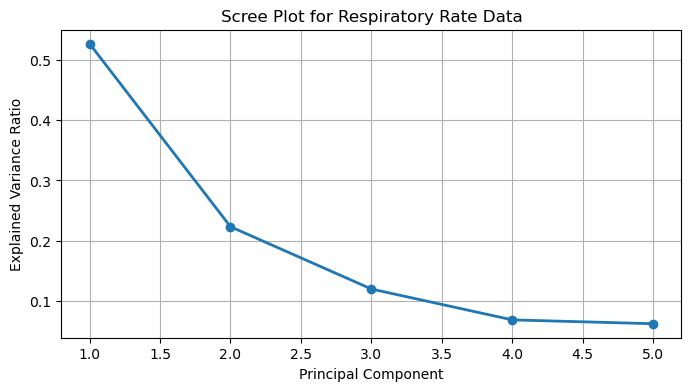

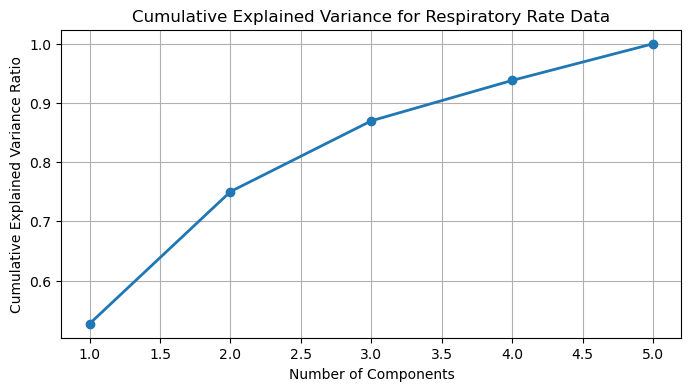

PCA Components for Respiratory Rate Data:


resprate_apache  d1_resprate_max  d1_resprate_min  h1_resprate_max  \
0         0.479118         0.426951         0.341057         0.501437   
1        -0.173571        -0.565189         0.685295        -0.179794   
2         0.655130         0.079766         0.332872        -0.523273   
3        -0.514807         0.473715         0.544440         0.133176   
4         0.214702        -0.517210         0.082663         0.651678   

   h1_resprate_min  
0         0.469468  
1         0.385330  
2        -0.424056  
3        -0.443191  
4        -0.504855

In [50]:
# PCA on Respiratory Rate Variables

# List of respiratory rate variables
resp_vars = [
    'resprate_apache', 'd1_resprate_max', 'd1_resprate_min',
    'h1_resprate_max', 'h1_resprate_min'
]

# Ensure variables are in the dataset
resp_vars = [var for var in resp_vars if var in data.columns]

# Extract respiratory rate data
resp_data = data[resp_vars]

# Handle missing values
resp_data = resp_data.dropna()

# Standardize the data
scaler = StandardScaler()
resp_data_scaled = scaler.fit_transform(resp_data)

# Perform PCA
pca_resp = PCA()
pca_resp.fit(resp_data_scaled)
resp_pca = pca_resp.transform(resp_data_scaled)

# Generate Scree Plot
explained_variance_resp = pca_resp.explained_variance_ratio_
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(explained_variance_resp) + 1), explained_variance_resp, 'o-', linewidth=2)
plt.title('Scree Plot for Respiratory Rate Data')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Cumulative explained variance
cumulative_explained_variance_resp = np.cumsum(explained_variance_resp)
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_explained_variance_resp) + 1), cumulative_explained_variance_resp, 'o-', linewidth=2)
plt.title('Cumulative Explained Variance for Respiratory Rate Data')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# PCA Components (Loadings)
resp_components = pd.DataFrame(pca_resp.components_, columns=resp_data.columns)
print("PCA Components for Respiratory Rate Data:")
display(resp_components)


In [51]:
# Respiratory Rate Variables to Drop
resp_vars_to_drop = ['h1_resprate_max', 'h1_resprate_min']

# Drop the variables from the dataset
data.drop(columns=resp_vars_to_drop, inplace=True)

In [52]:
comorbidity_vars = [
    'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]
data['comorbidity_count'] = data[comorbidity_vars].astype(int).sum(axis=1)
data['gcs_total'] = data['gcs_eyes_apache'] + data['gcs_motor_apache'] + data['gcs_verbal_apache']



Numerical Features: ['age', 'bmi', 'height', 'pre_icu_los_days', 'weight', 'apache_2_diagnosis', 'apache_3j_diagnosis', 'gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache', 'heart_rate_apache', 'map_apache', 'resprate_apache', 'temp_apache', 'd1_diasbp_max', 'd1_diasbp_min', 'd1_heartrate_max', 'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_resprate_max', 'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max', 'd1_sysbp_min', 'd1_temp_max', 'd1_temp_min', 'd1_glucose_max', 'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min', 'comorbidity_count', 'gcs_total']
Categorical Features: ['diabetes_mellitus', 'ethnicity_Asian', 'gender_M', 'icu_type_Neuro ICU', 'arf_apache', 'ethnicity_Native American', 'icu_stay_type_readmit', 'aids', 'icu_type_CTICU', 'ventilated_apache', 'icu_type_MICU', 'apache_2_bodysystem_Neurologic', 'icu_type_Med-Surg ICU', 'apache_2_bodysystem_Respiratory', 'apache_3j_bodysystem_Metabolic', 'leukemia', 'apache_3j_bodysystem_Hematological', 'i

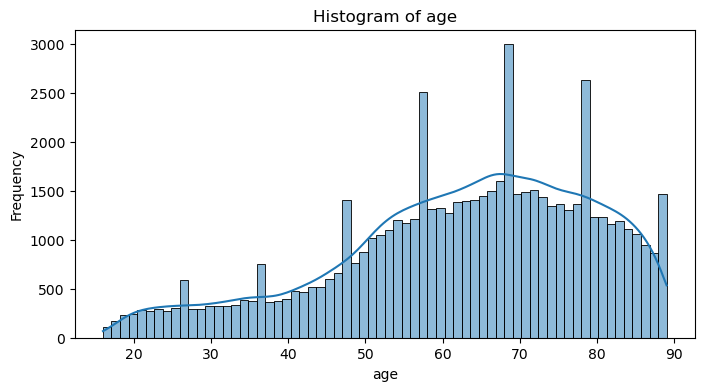

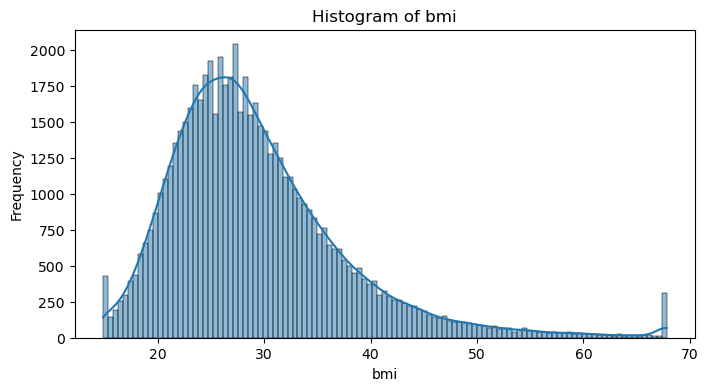

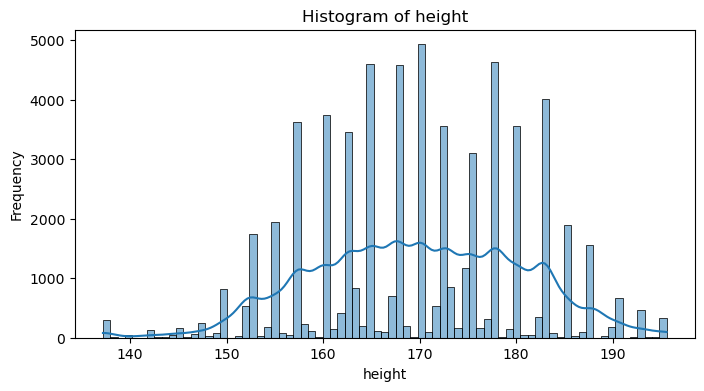

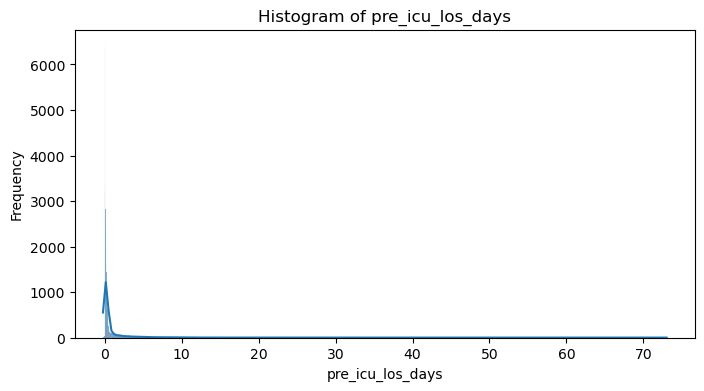

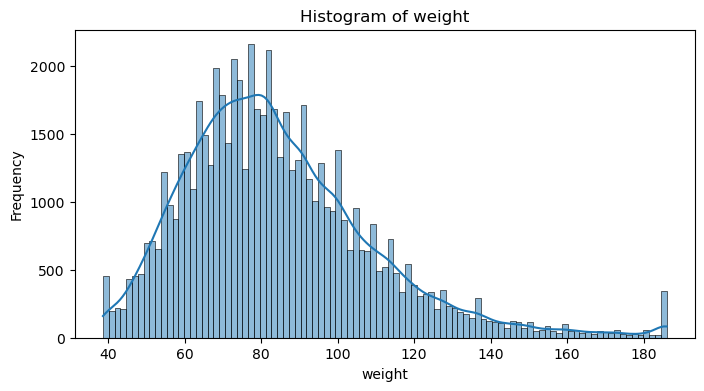

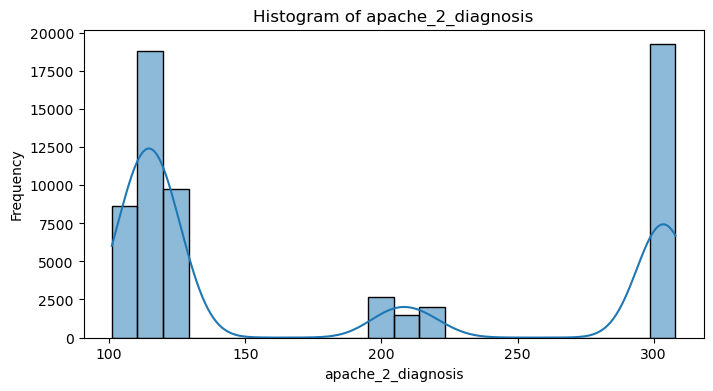

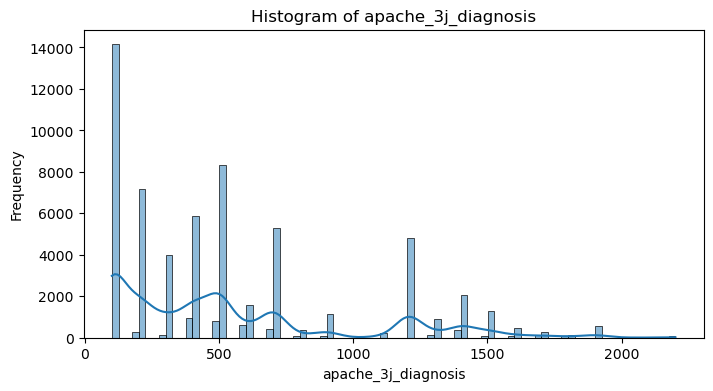

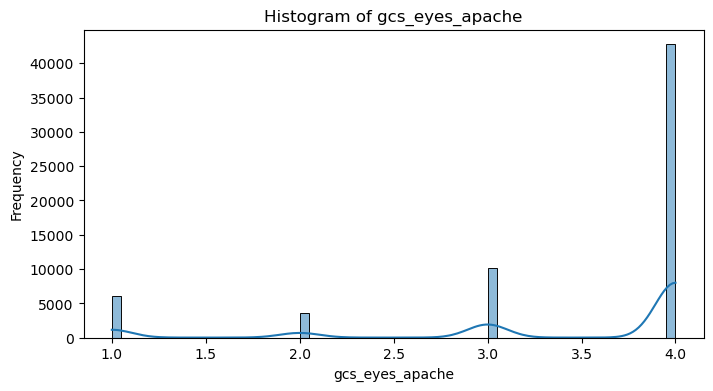

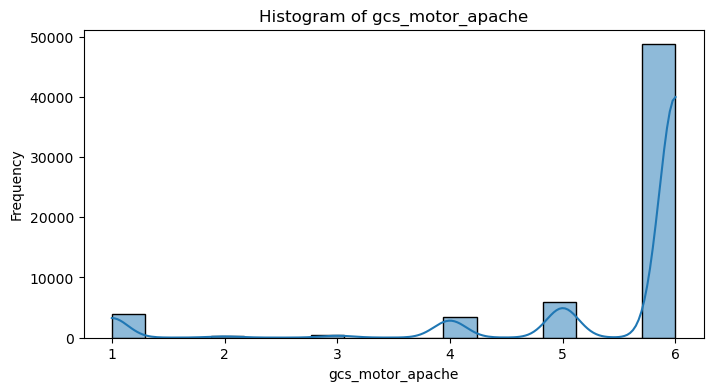

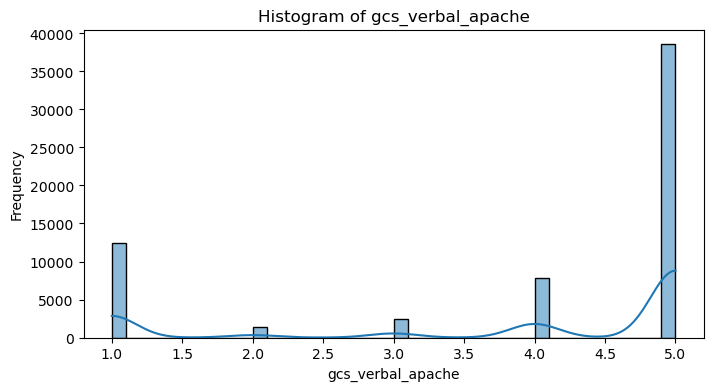

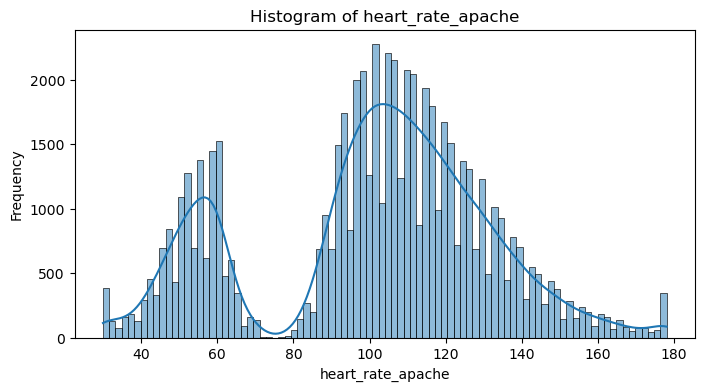

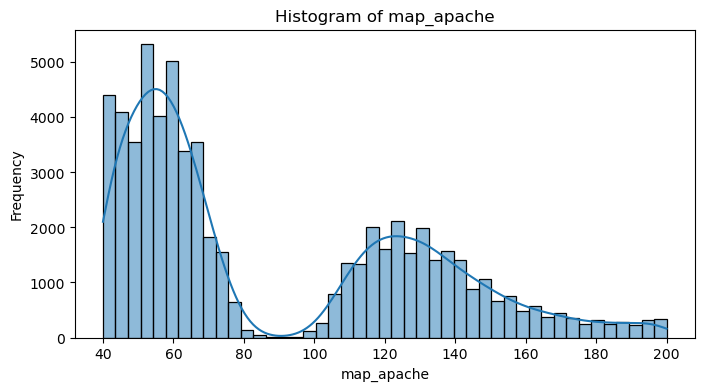

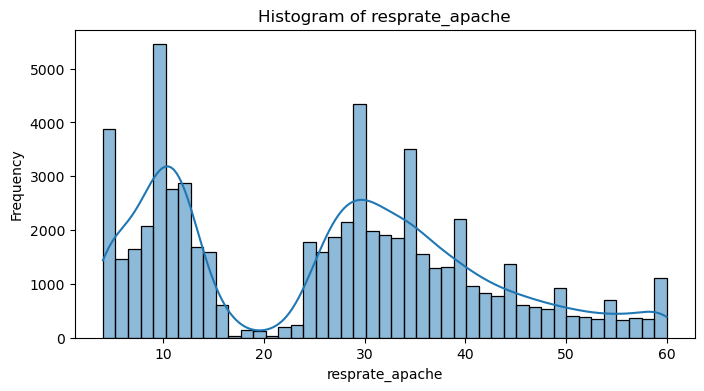

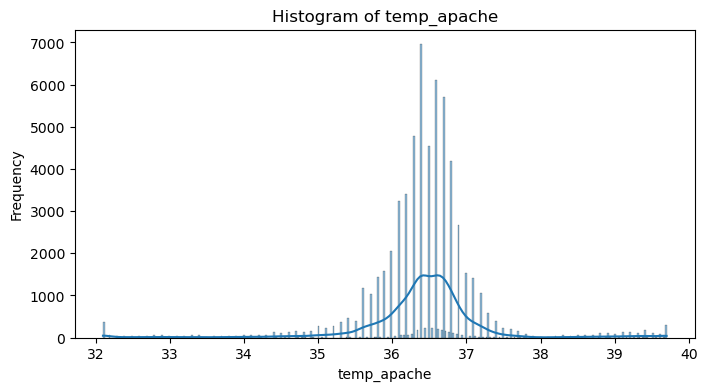

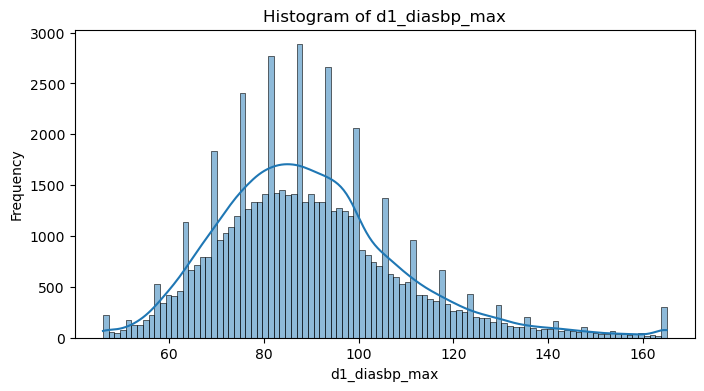

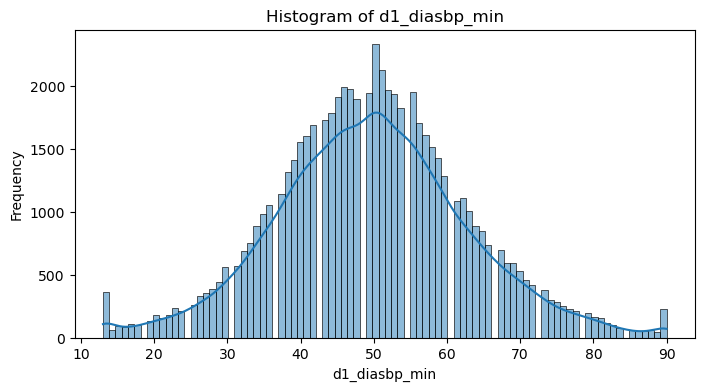

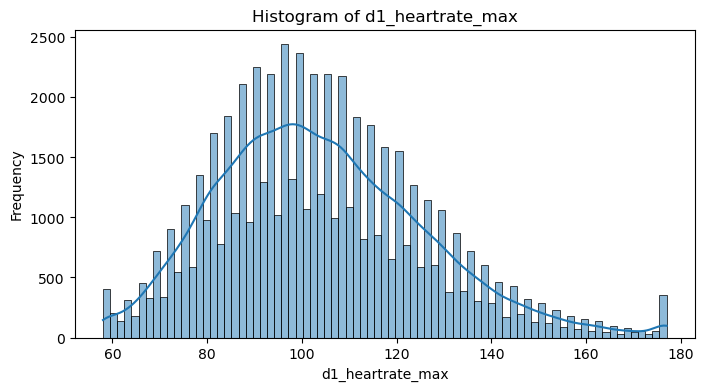

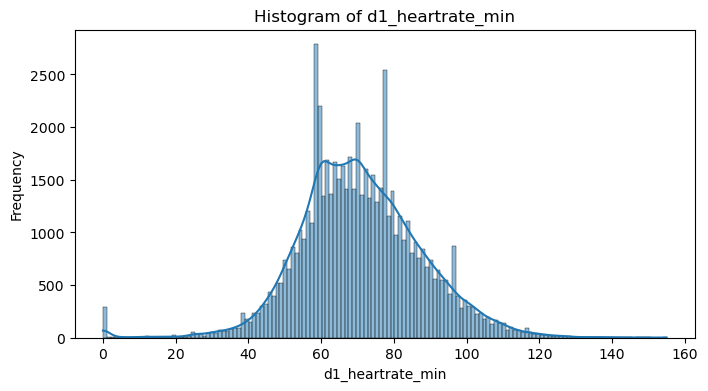

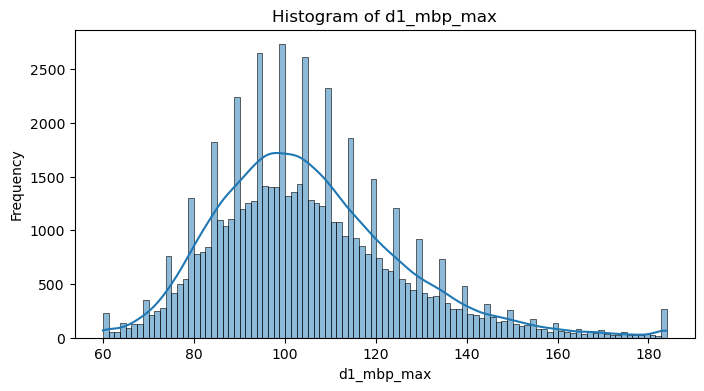

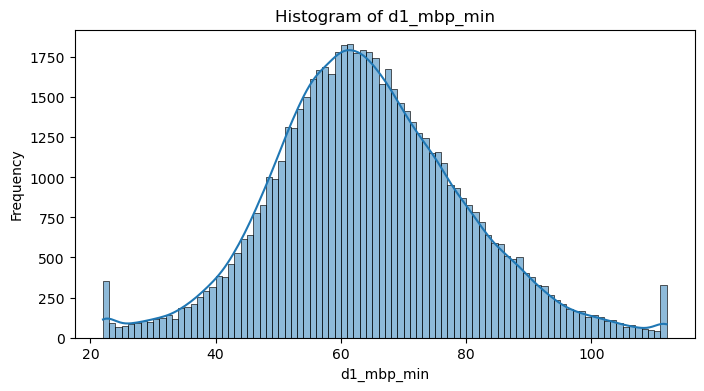

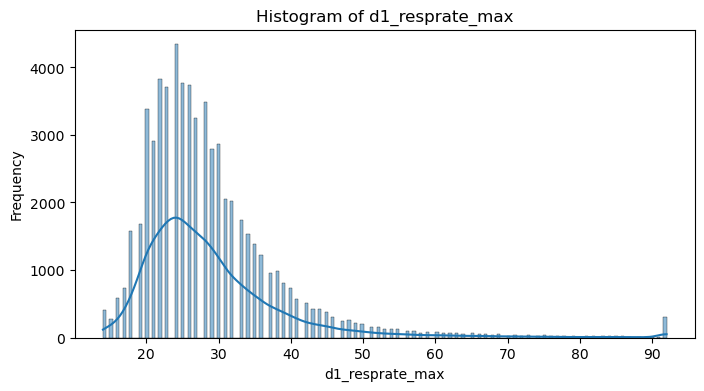

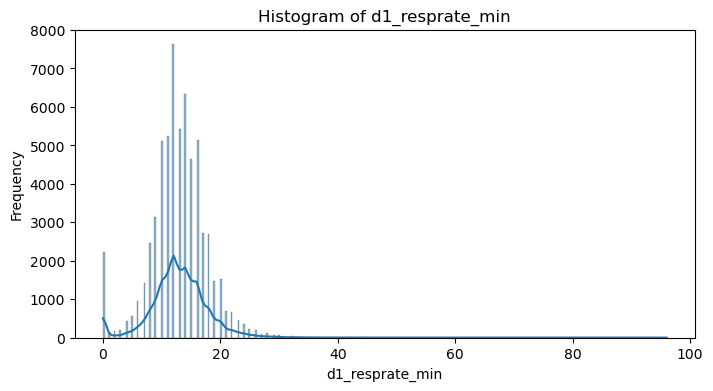

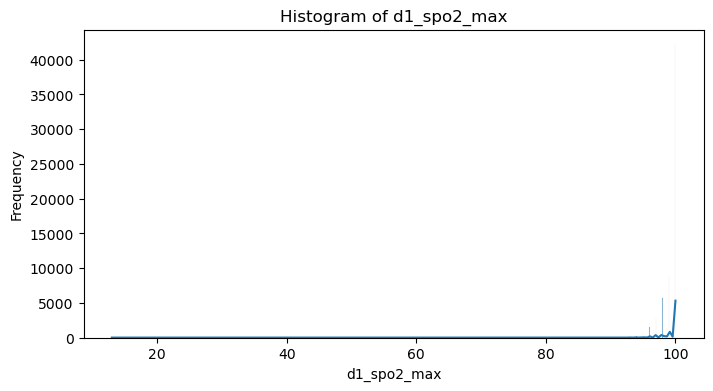

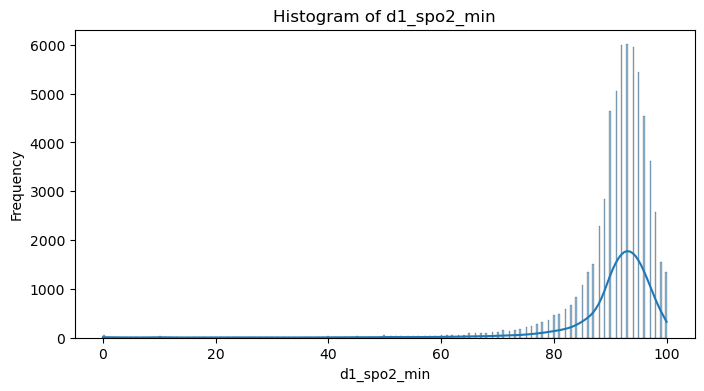

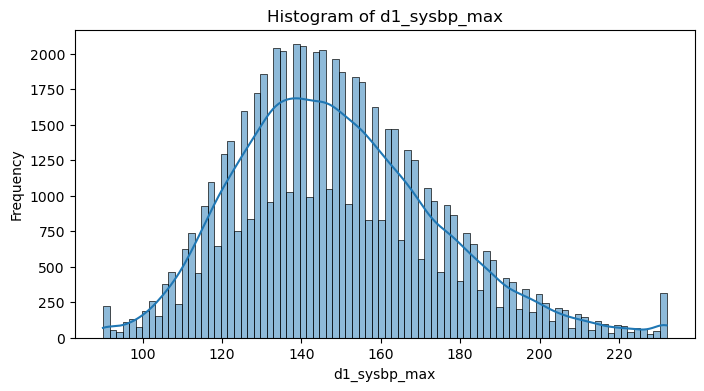

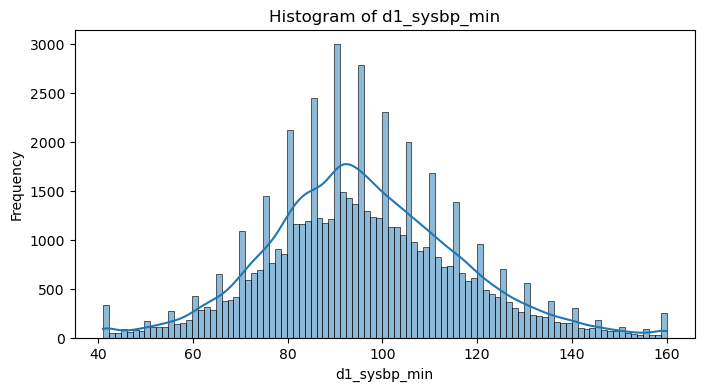

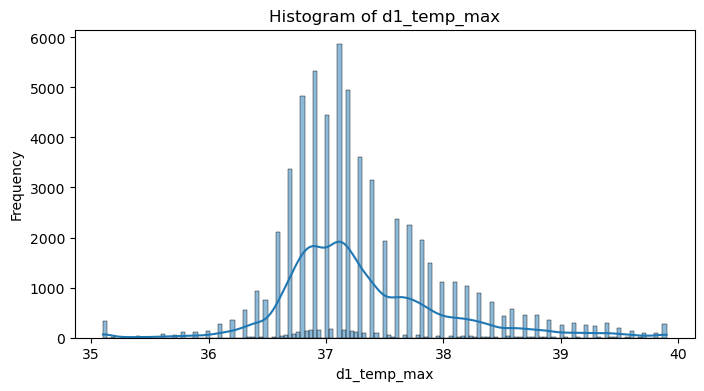

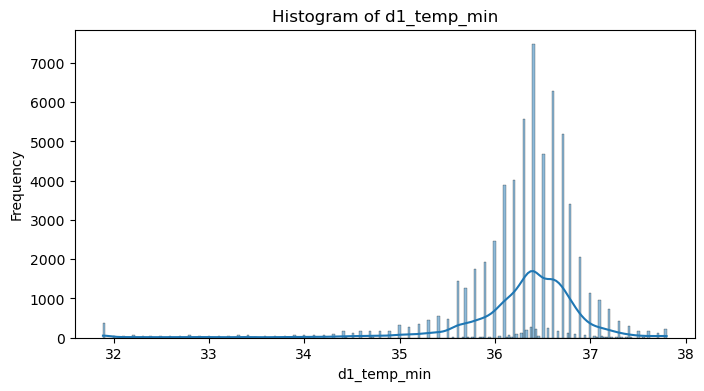

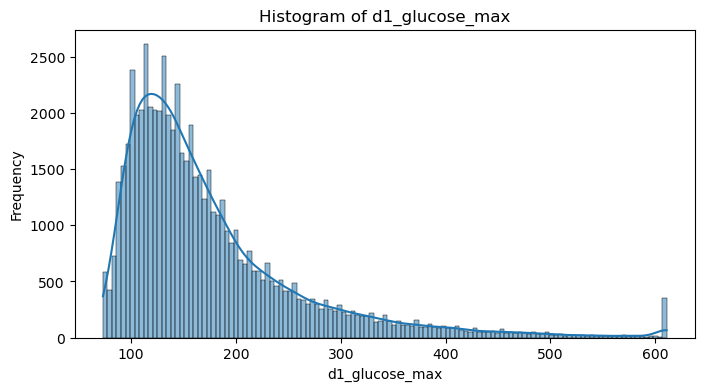

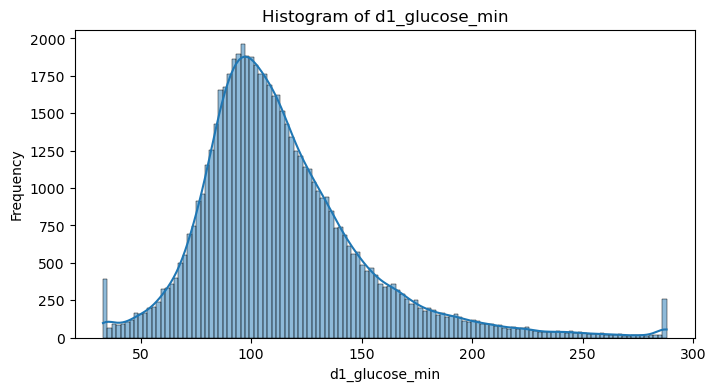

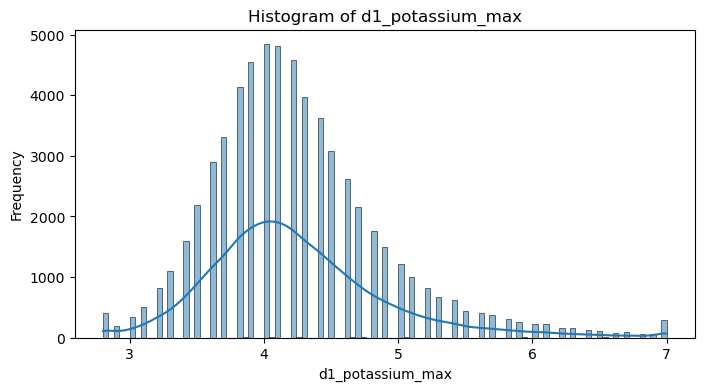

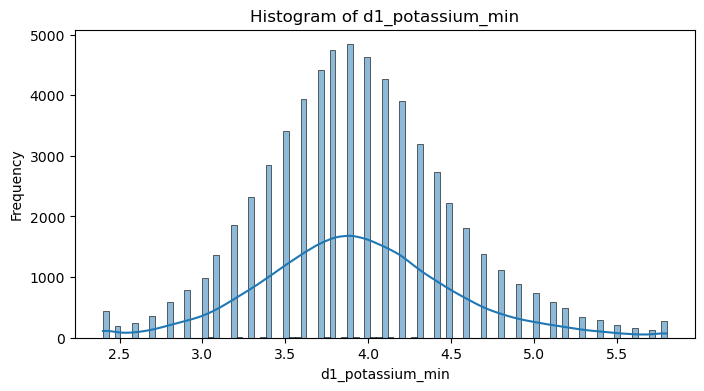

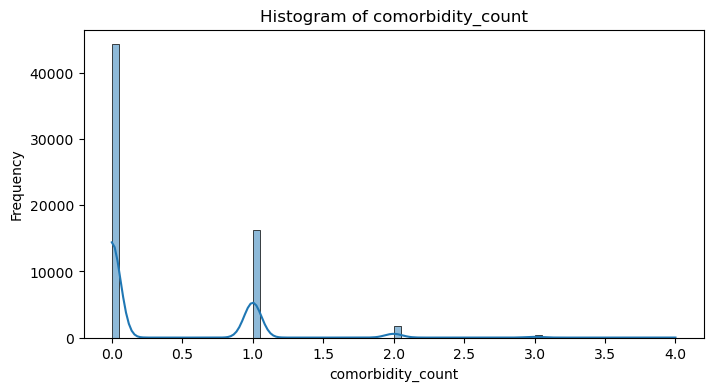

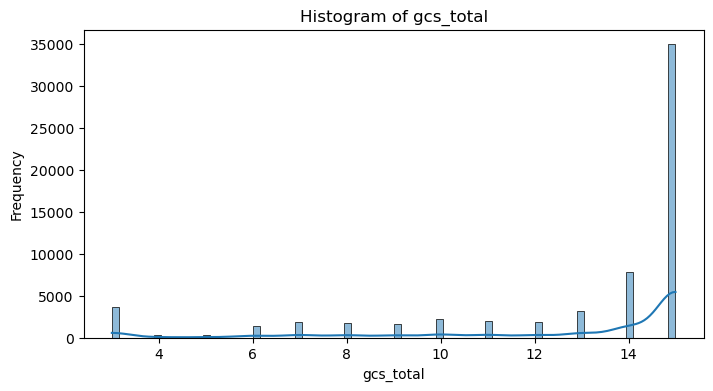

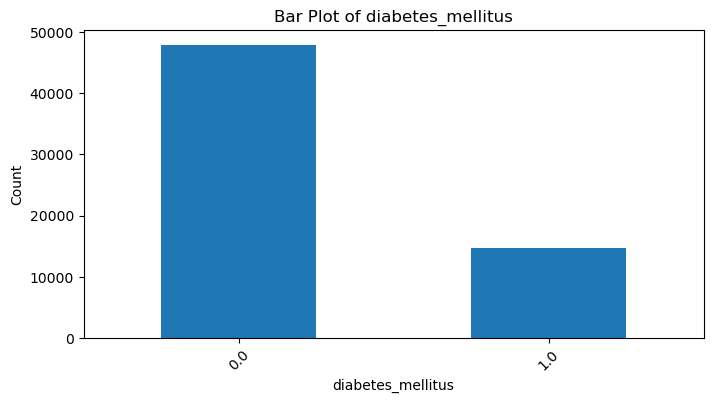

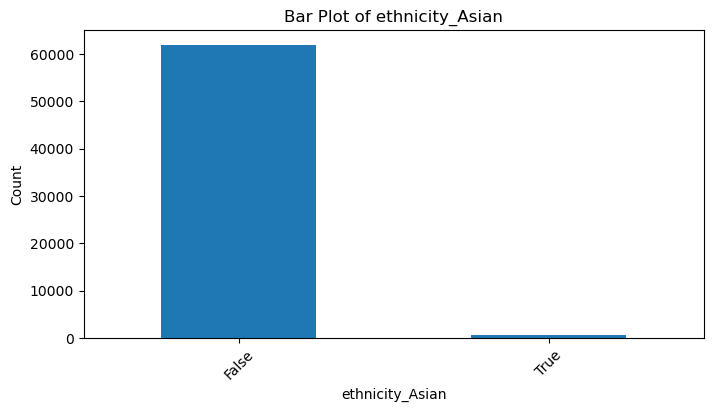

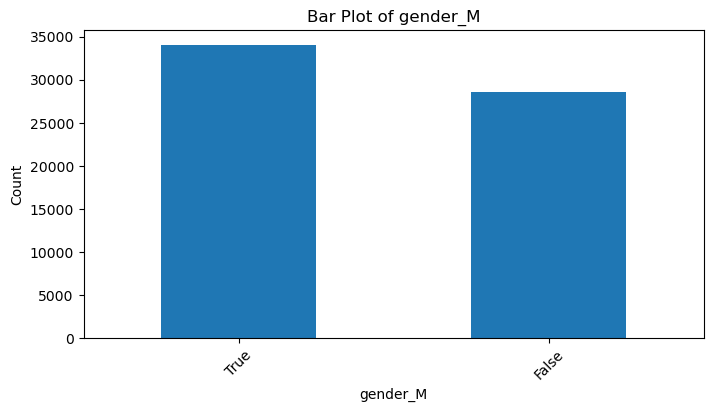

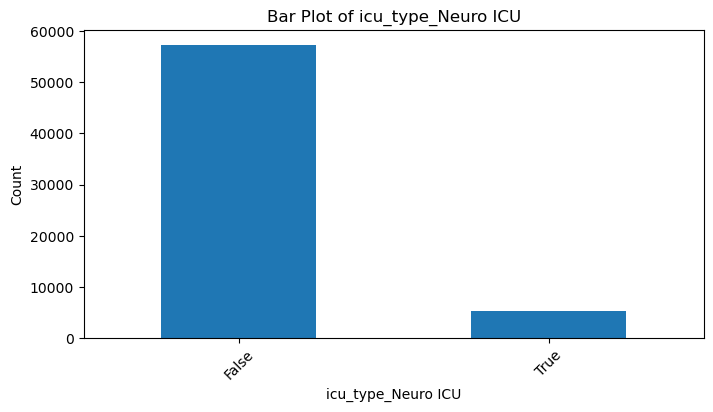

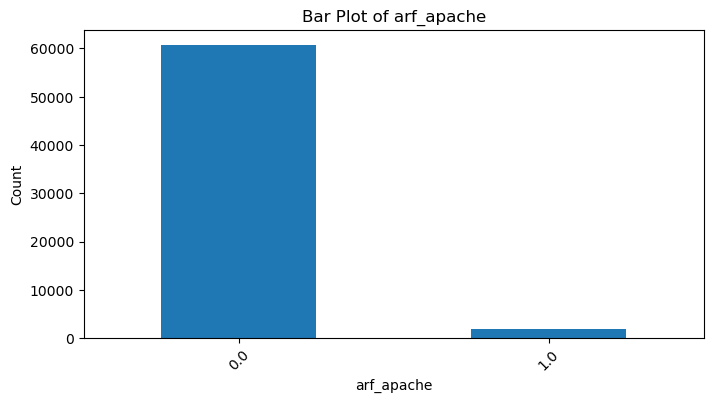

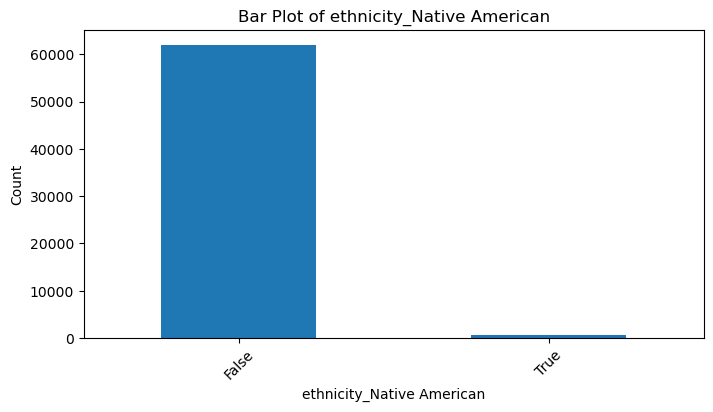

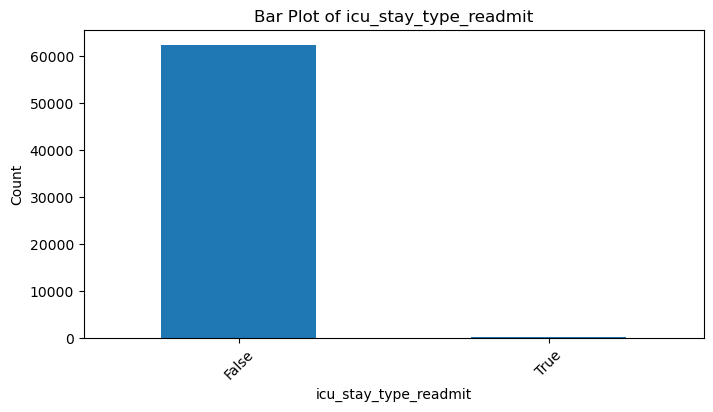

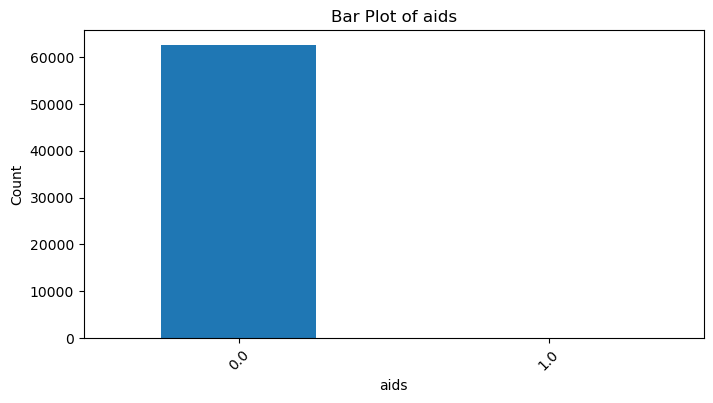

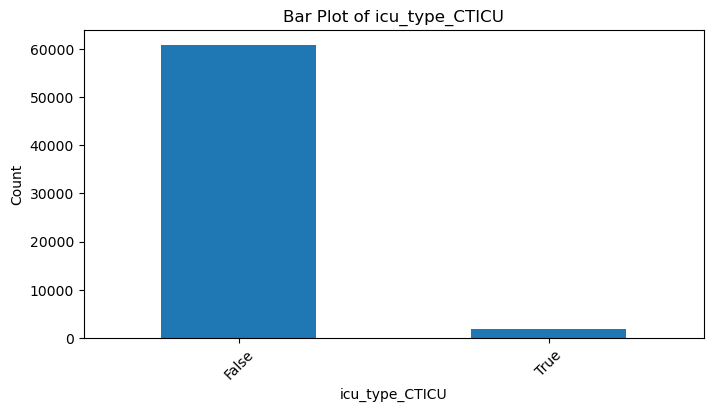

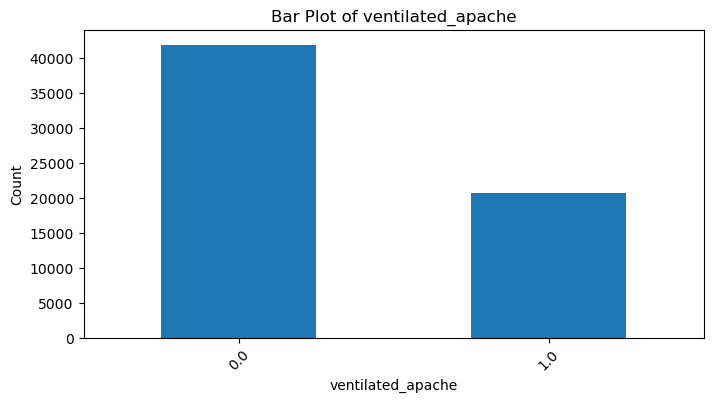

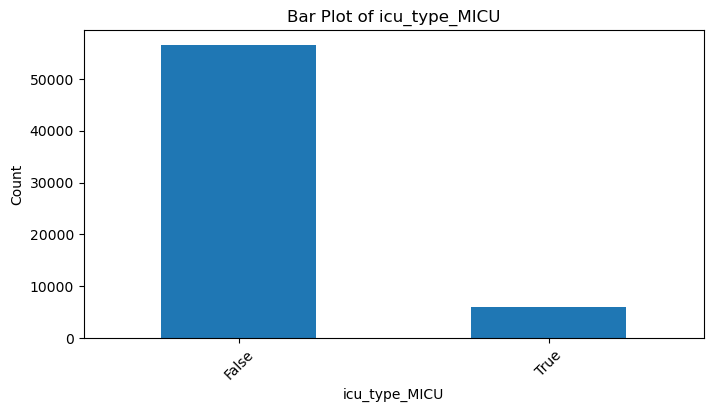

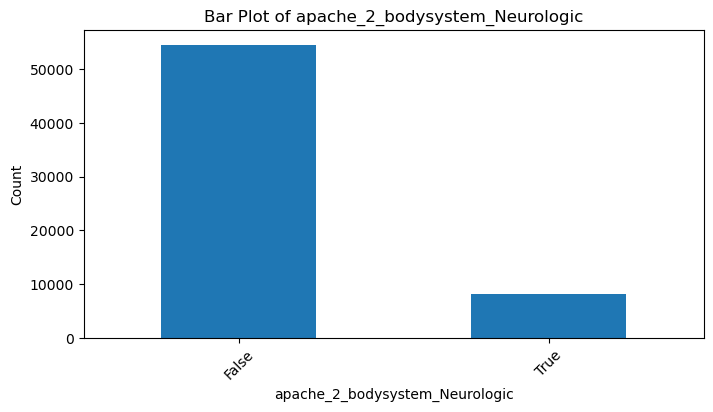

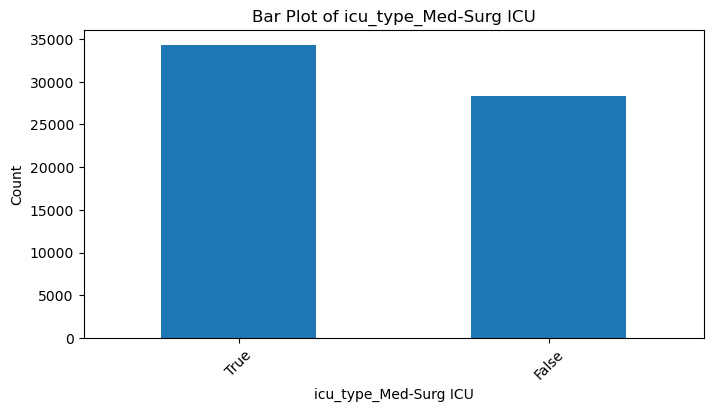

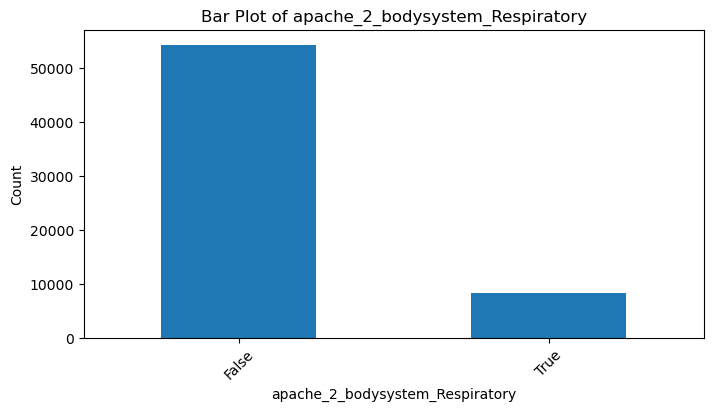

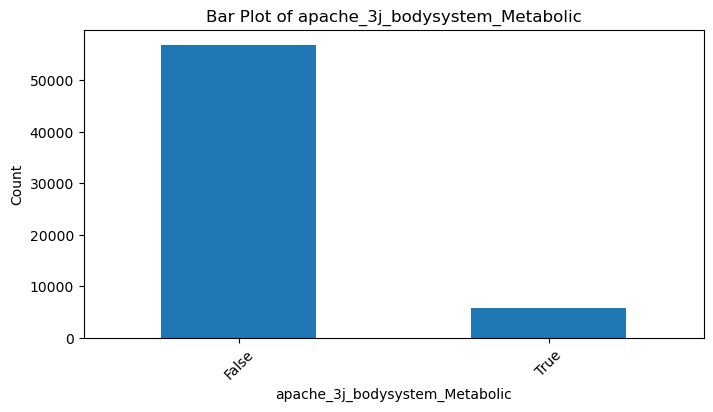

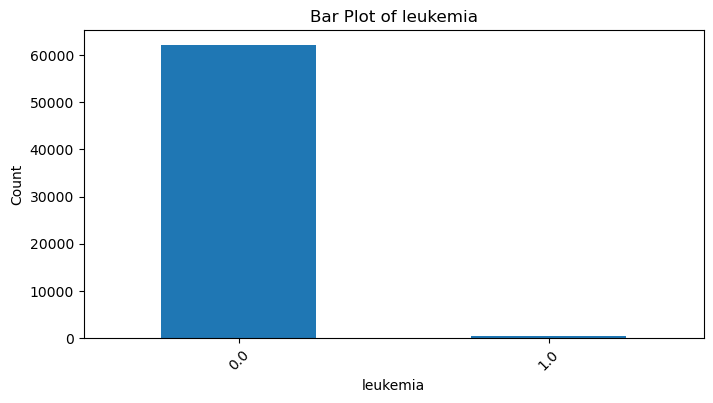

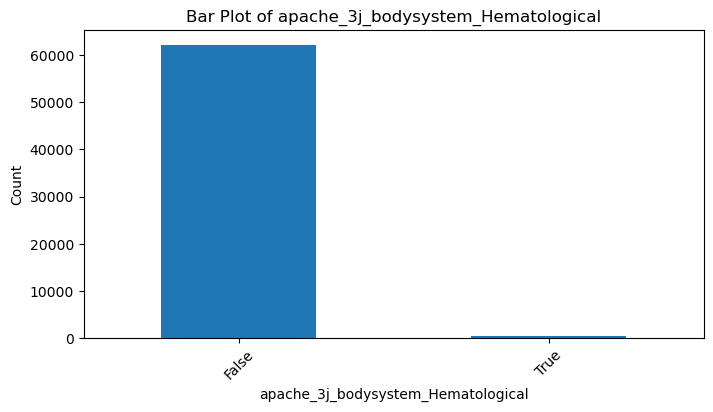

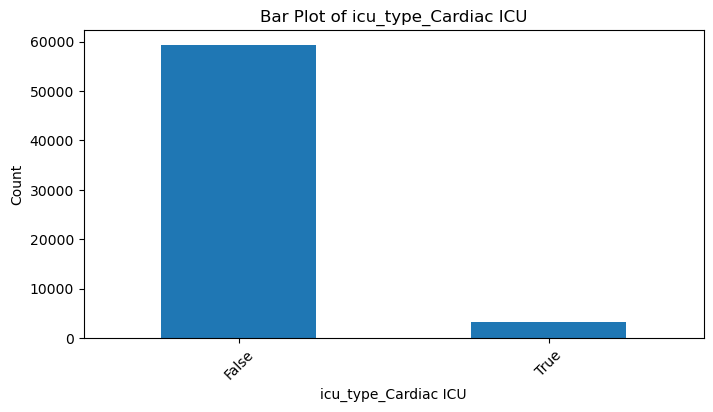

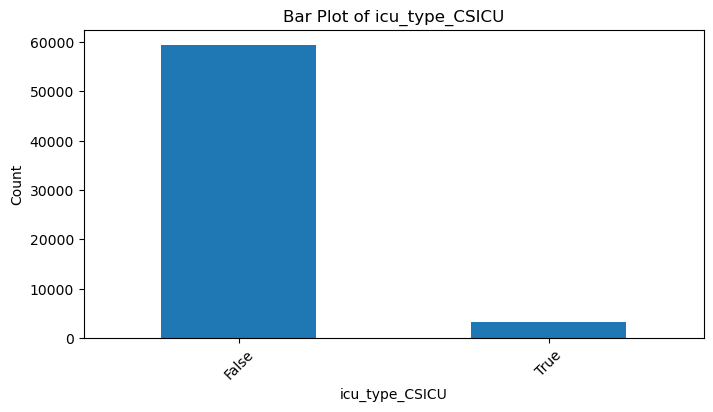

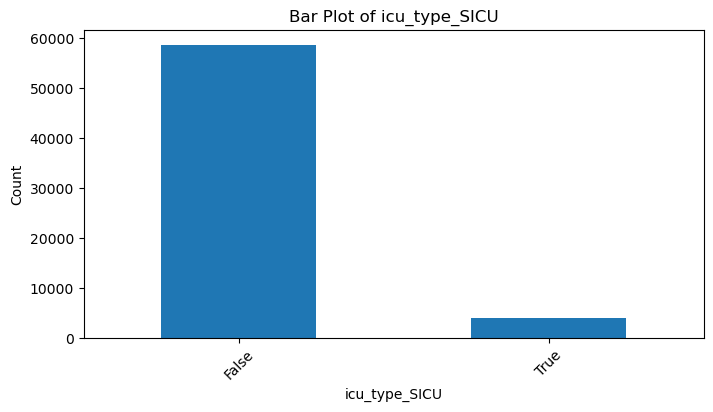

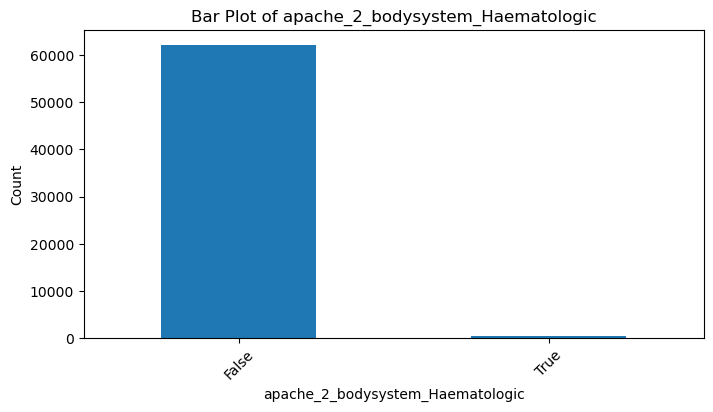

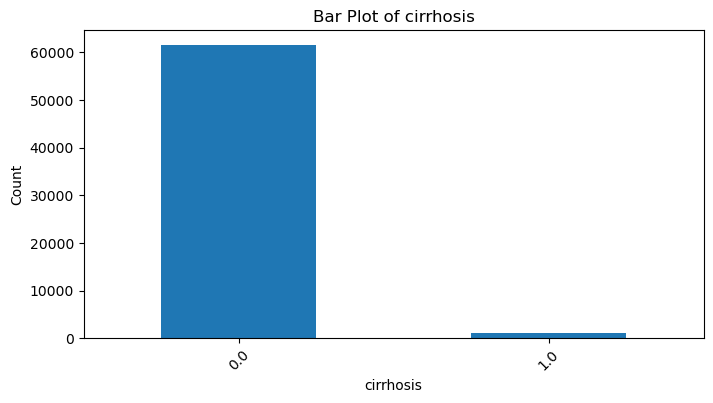

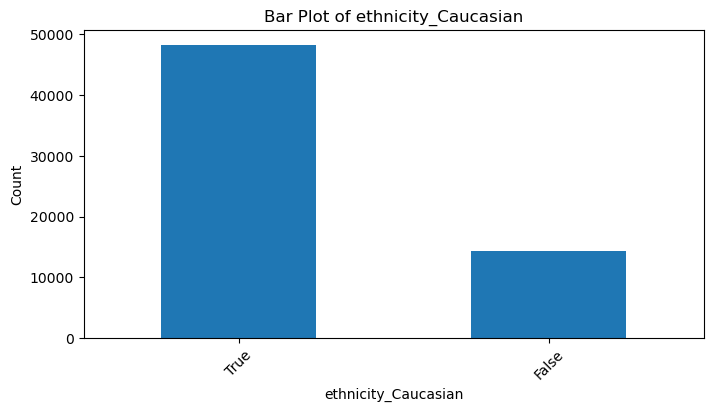

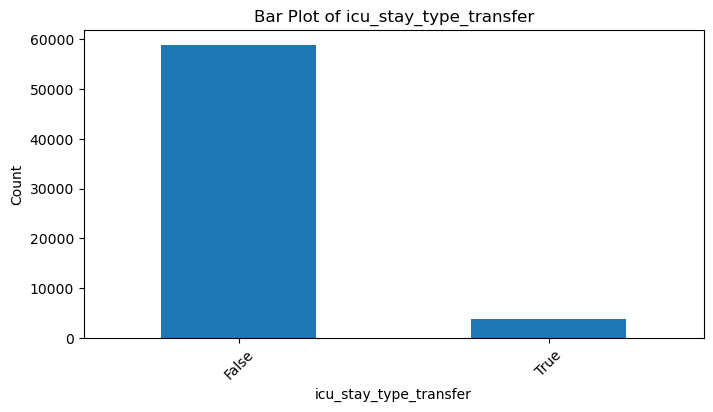

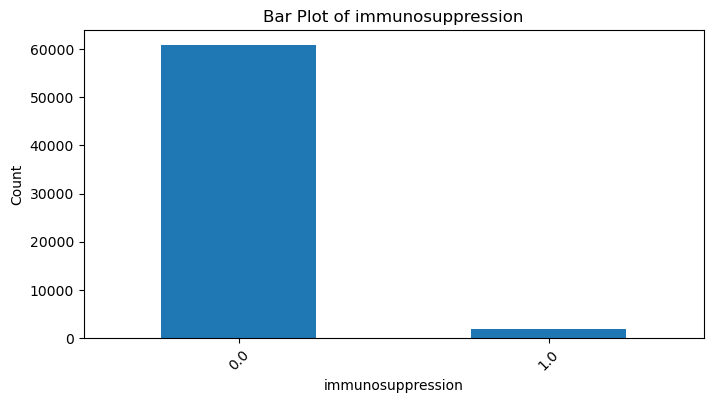

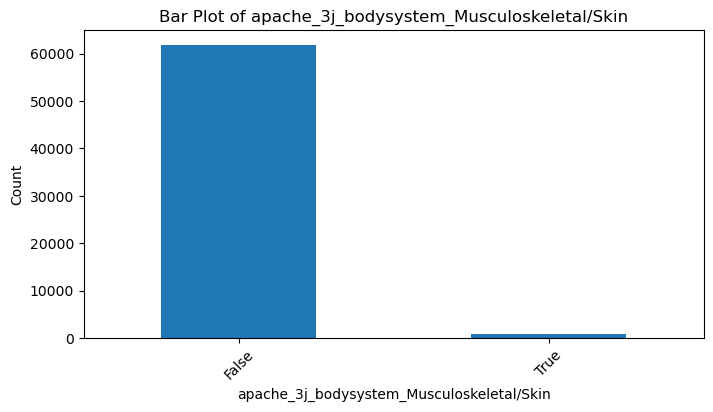

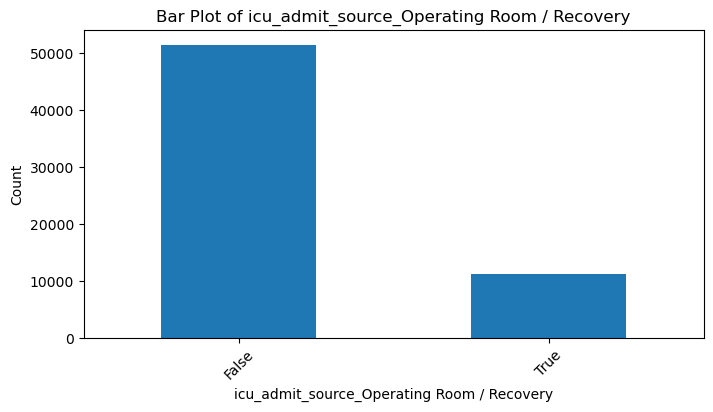

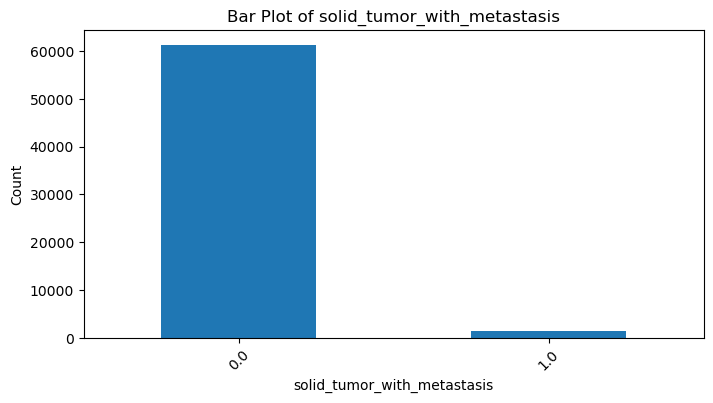

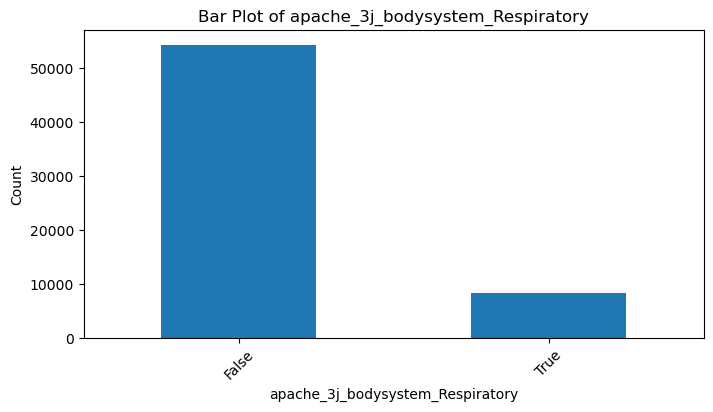

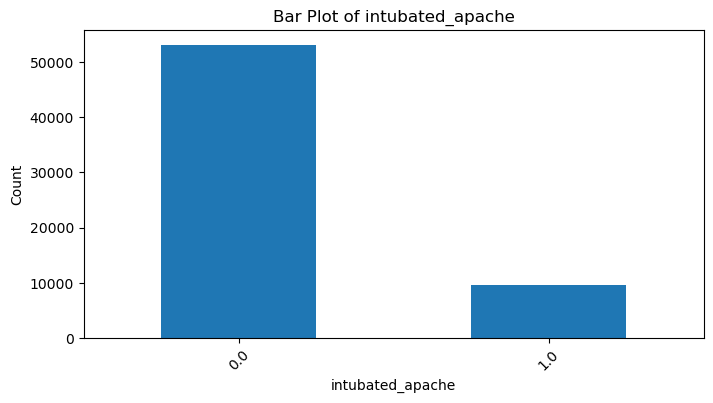

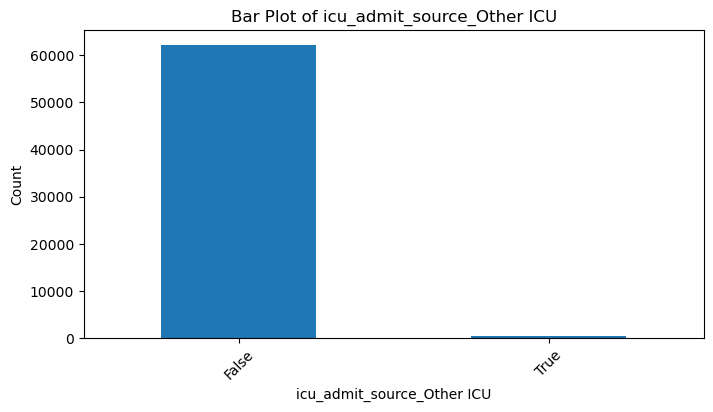

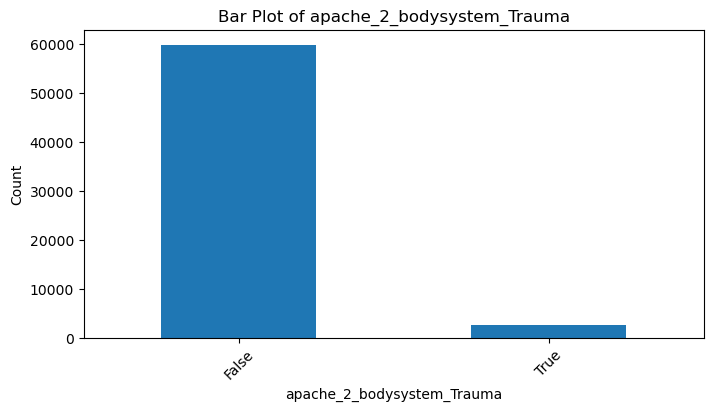

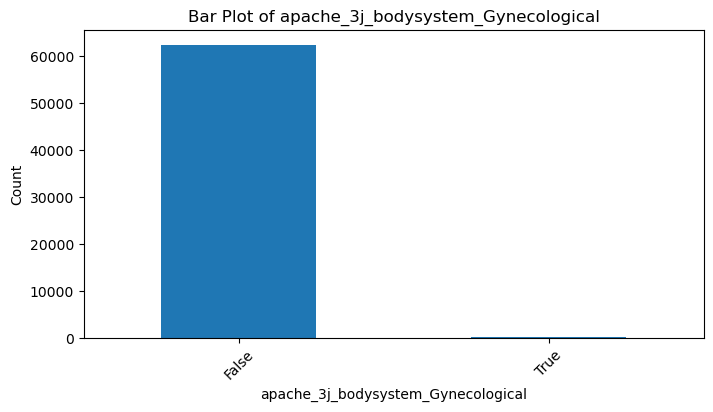

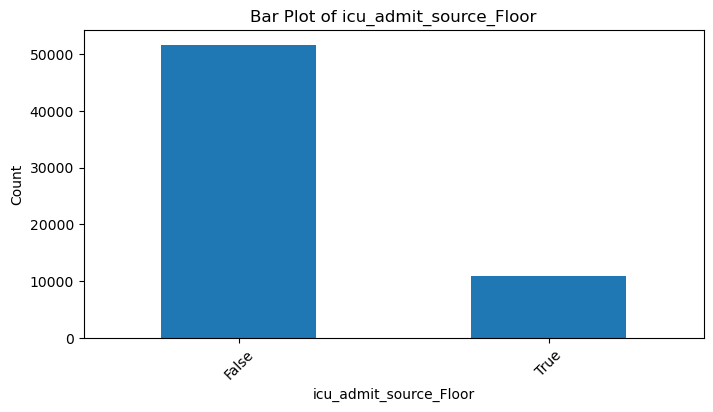

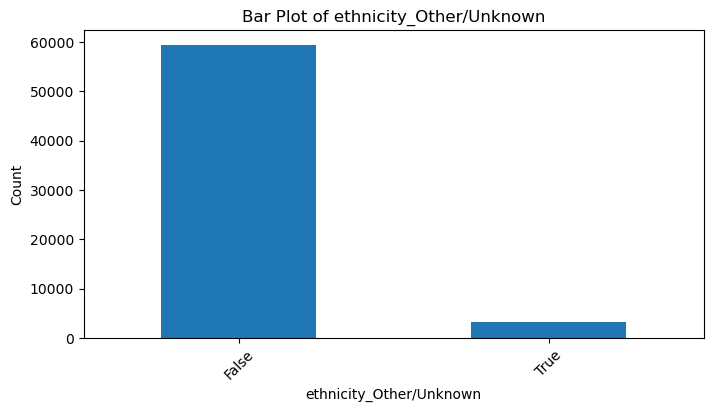

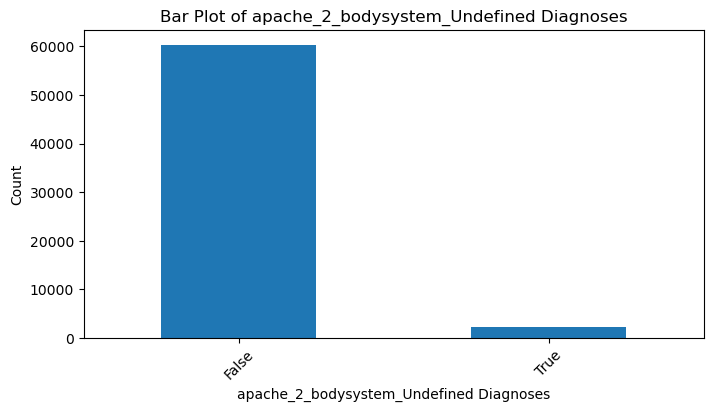

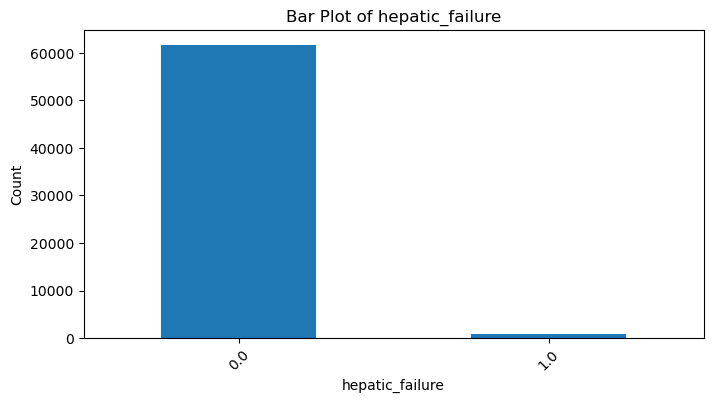

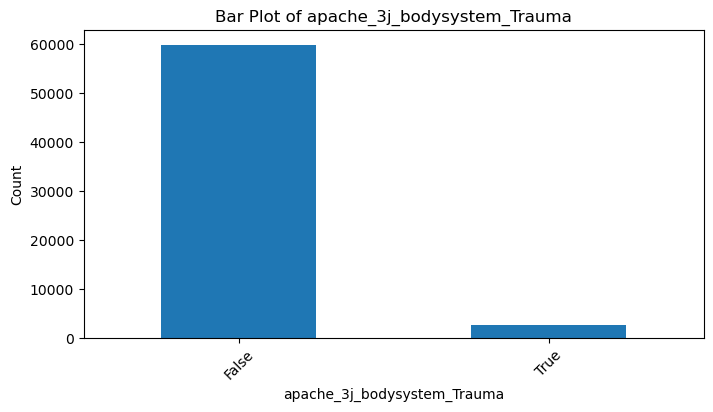

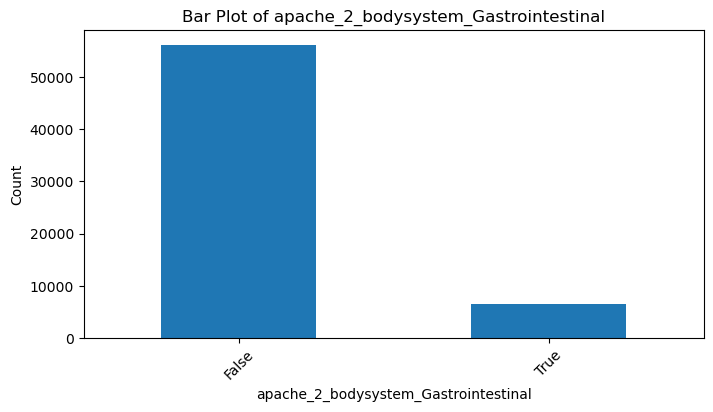

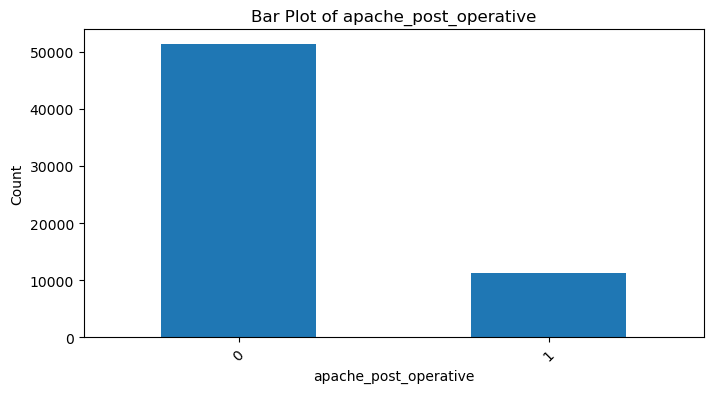

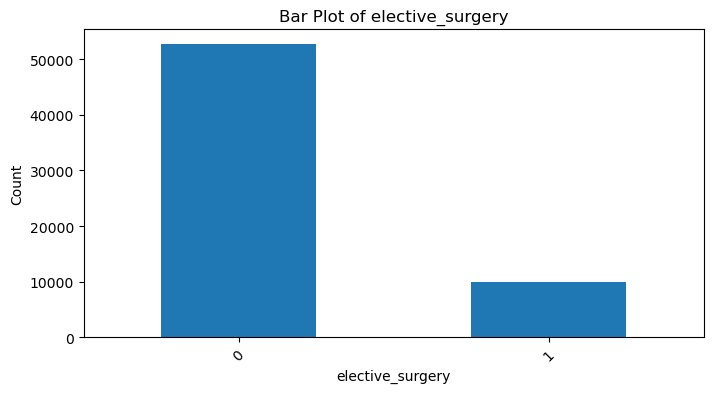

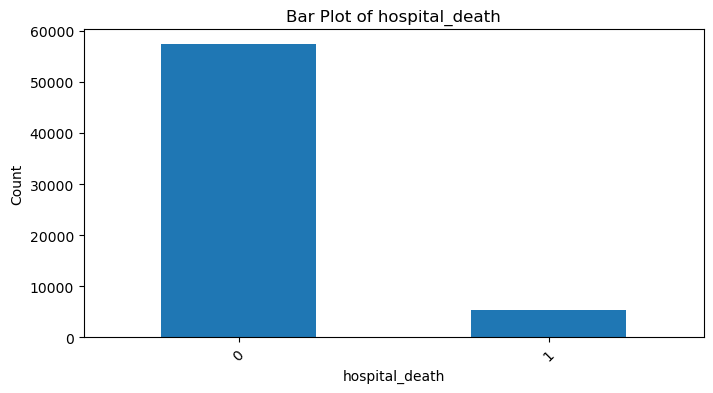

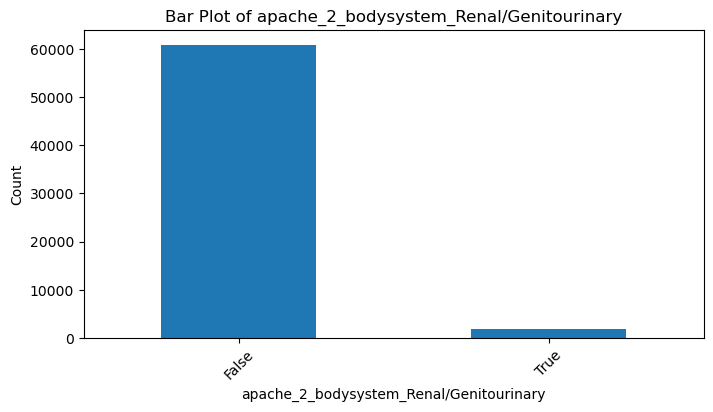

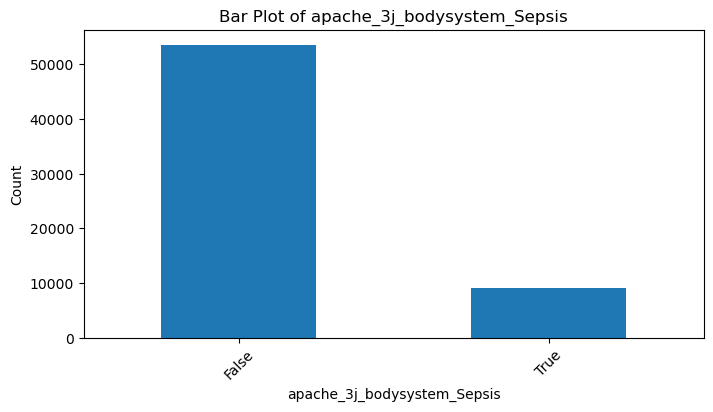

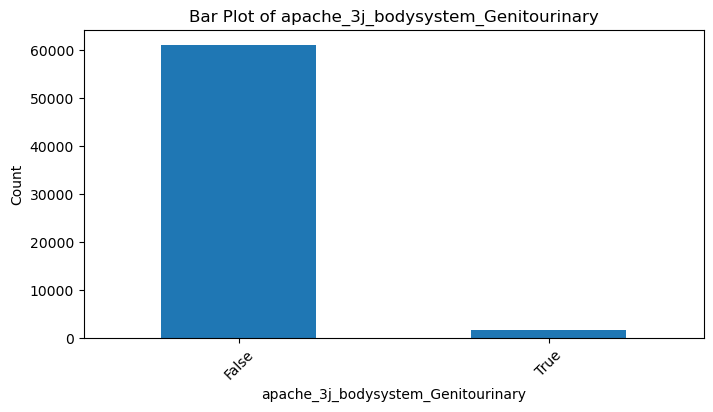

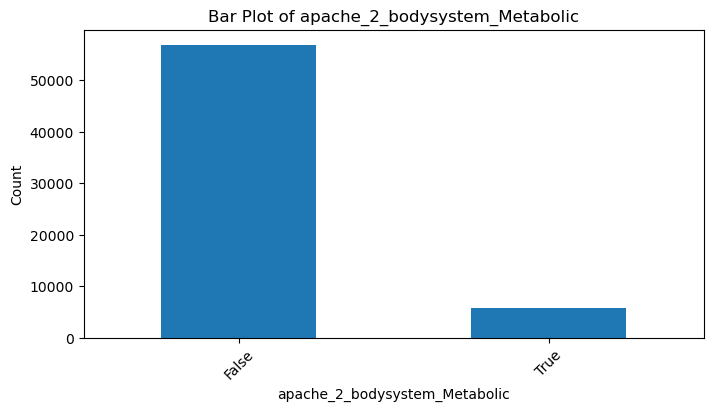

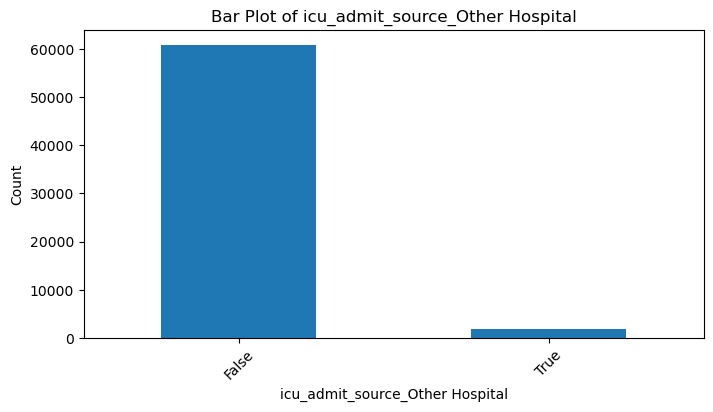

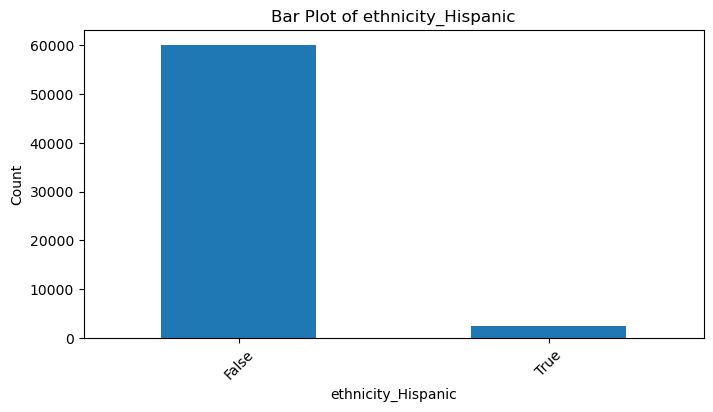

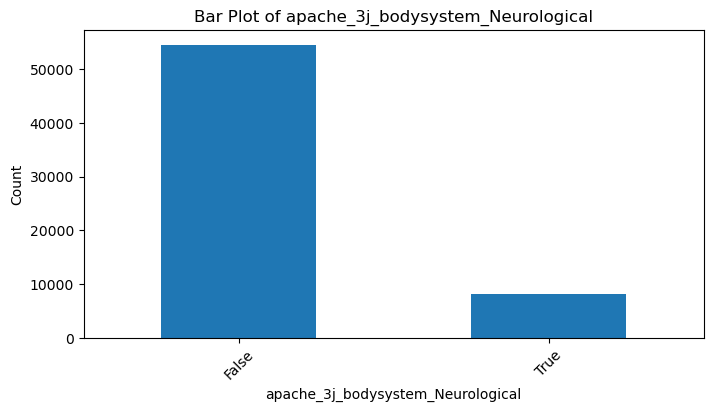

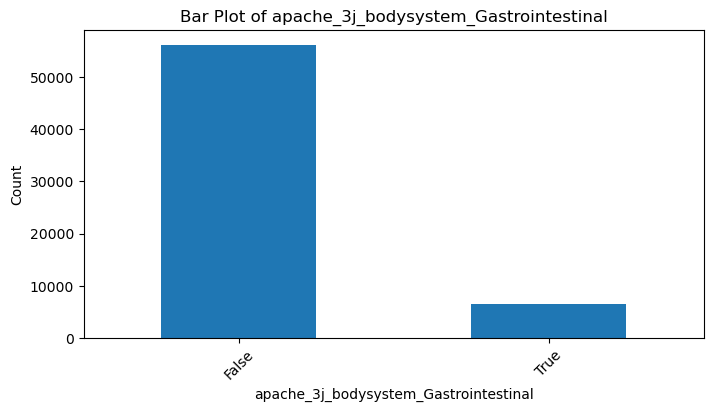

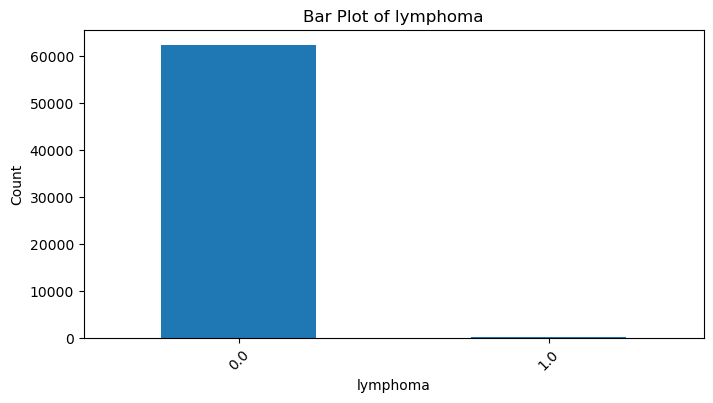

In [53]:
# Identify numerical and categorical features in the dataset

# Select numerical features (excluding the target 'hospital_death' if included)
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'hospital_death' in numerical_features:
    numerical_features.remove('hospital_death')  # Exclude target variable from numerical features

# Select categorical features, including binary variables (0 and 1) as categorical
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
binary_categorical_columns = [col for col in data.columns if data[col].nunique() == 2 and sorted(data[col].unique()) == [0, 1]]
categorical_features.extend(binary_categorical_columns)  # Add binary categorical columns to categorical features

# Remove any duplicates if a column is mistakenly added twice
categorical_features = list(set(categorical_features))

# Display lists of numerical and categorical features for confirmation
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

# Now proceed with the visualizations
# For numerical features, plot histograms
for col in numerical_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# For categorical features, plot bar plots
for col in categorical_features:
    plt.figure(figsize=(8, 4))
    data[col].value_counts().plot(kind='bar')
    plt.title(f'Bar Plot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

VIF Scores:
                feature          VIF
0                   age    17.411767
1                   bmi   296.455241
2                height  1428.812930
3      pre_icu_los_days     1.145585
4                weight   322.720916
5    apache_2_diagnosis     6.707469
6   apache_3j_diagnosis     3.130052
7       gcs_eyes_apache    49.634407
8      gcs_motor_apache    53.264694
9     gcs_verbal_apache    19.137841
10    heart_rate_apache    40.211928
11           map_apache     8.768514
12      resprate_apache     7.319228
13          temp_apache  1574.081717
14        d1_diasbp_max    86.226066
15        d1_diasbp_min    67.131106
16     d1_heartrate_max    78.530310
17     d1_heartrate_min    32.286187
18           d1_mbp_max   161.126635
19           d1_mbp_min    87.877736
20      d1_resprate_max    14.368629
21      d1_resprate_min    10.259074
22          d1_spo2_max  2189.706291
23          d1_spo2_min   106.745242
24         d1_sysbp_max    90.189379


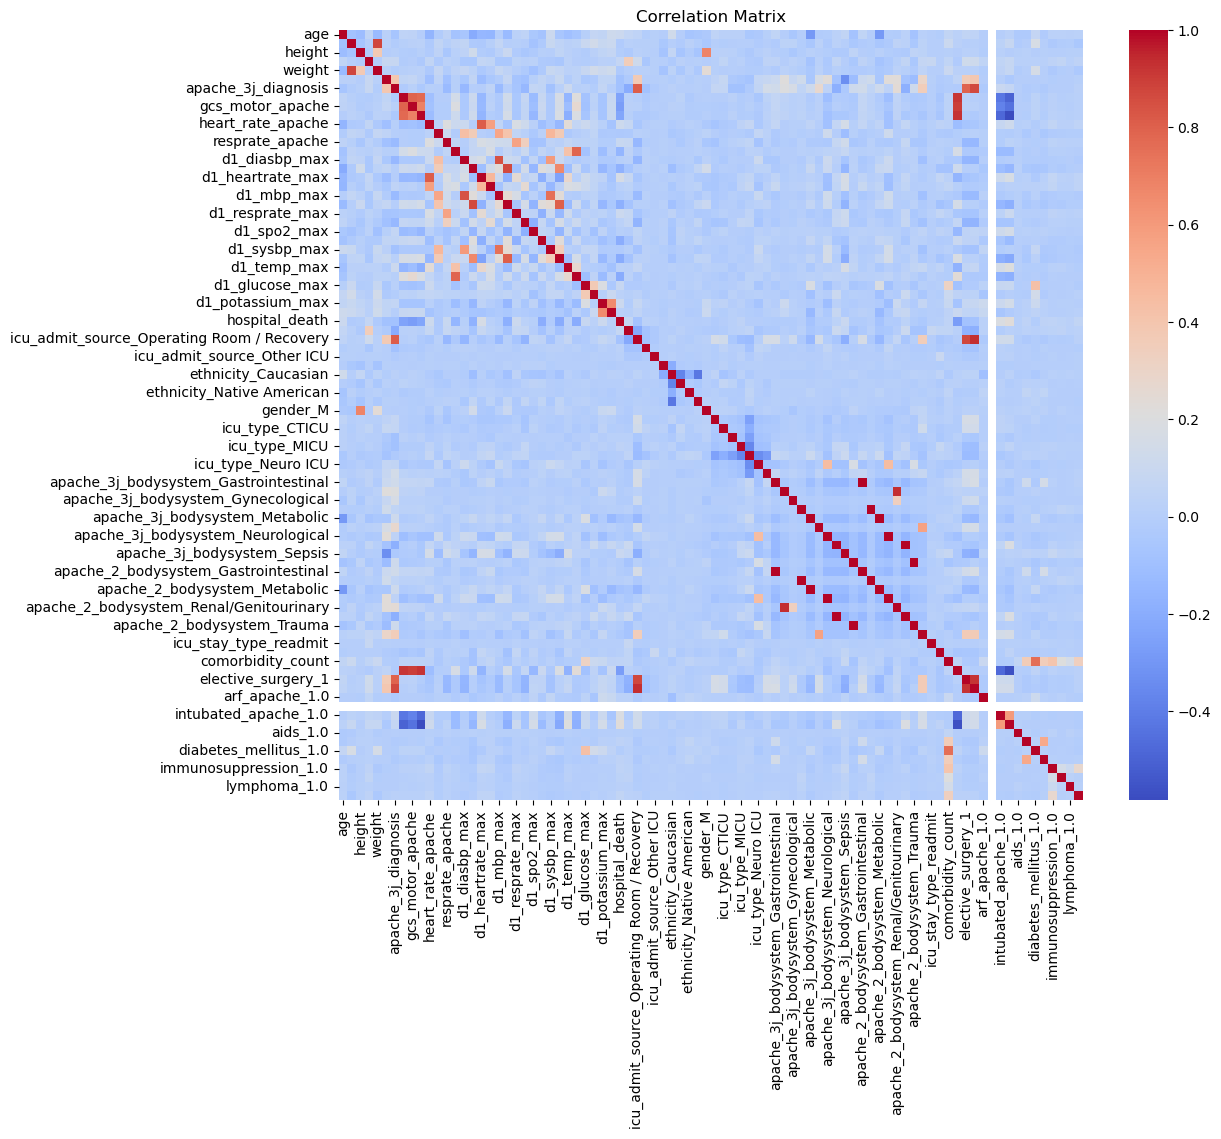

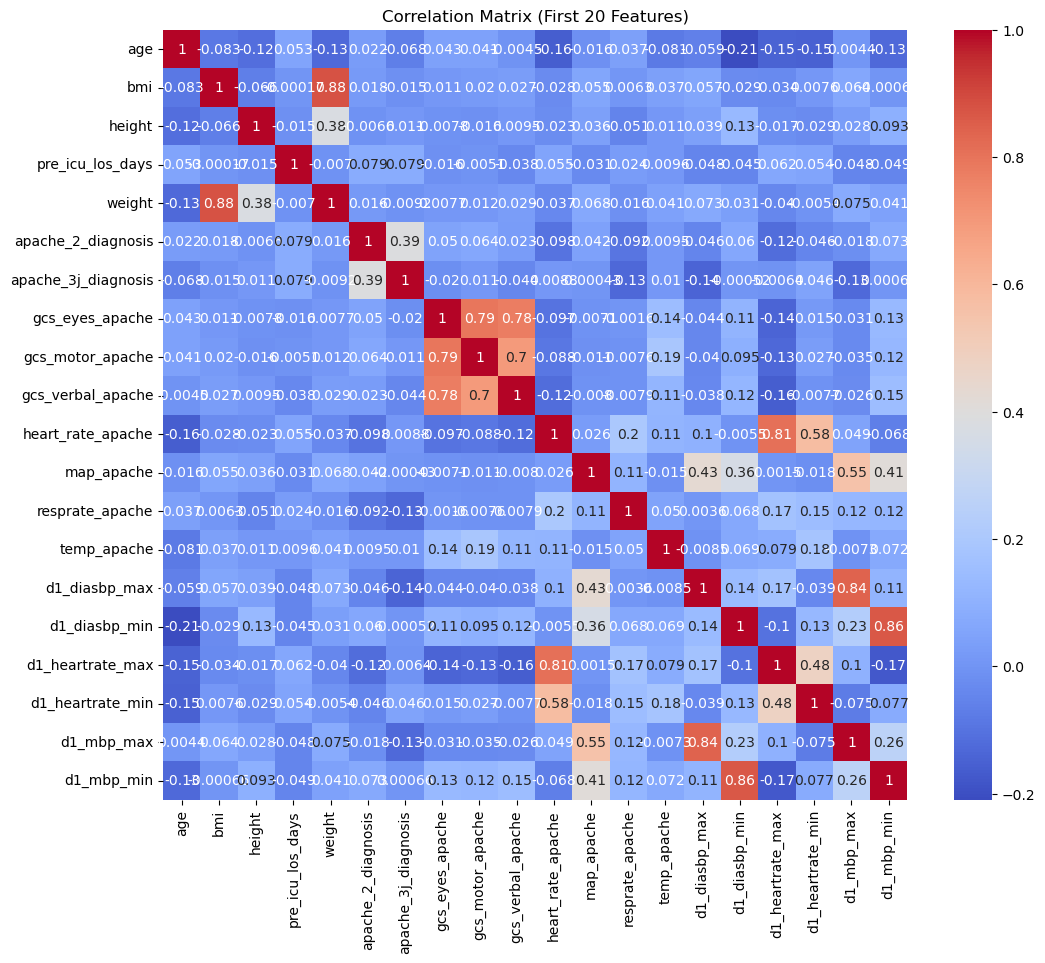

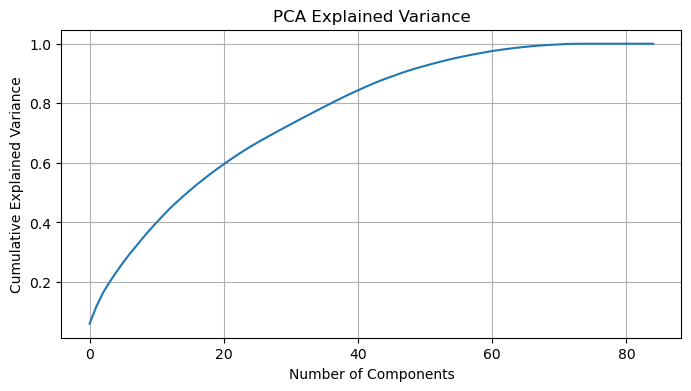

In [54]:
# Cell 4: Multicollinearity Analysis

# One-hot encode categorical variables for correlation and VIF calculations
data_encoded = pd.get_dummies(data, drop_first=True)

# Prepare the features for VIF calculation (exclude the target variable)
X = data_encoded.drop('hospital_death', axis=1)

# Calculate VIF scores (only useful for linear tho)
vif_features = X.columns[:25]  # Adjust as needed
X_vif = X[vif_features]

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("VIF Scores:")
print(vif_data)

# Correlation matrix
plt.figure(figsize=(12, 10))
corr_matrix = data_encoded.corr()
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Select only the first 20 features for the correlation matrix
subset_corr_matrix = data_encoded.iloc[:, :20].corr()

# Plot the correlation matrix for the selected subset
plt.figure(figsize=(12, 10))
sns.heatmap(subset_corr_matrix, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix (First 20 Features)')
plt.show()

# PCA for multicollinearity

# Standardize the data before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


pca = PCA()
pca.fit(X_scaled)

# Plot cumulative explained variance ratio
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()



Skewness of Numerical Features:
age                    -0.626859
bmi                     1.425780
height                 -0.107859
pre_icu_los_days        8.333064
weight                  1.074524
apache_2_diagnosis      0.588129
apache_3j_diagnosis     1.111871
gcs_eyes_apache        -1.581937
gcs_motor_apache       -2.634360
gcs_verbal_apache      -1.112972
heart_rate_apache      -0.310481
map_apache              0.690700
resprate_apache         0.229568
temp_apache            -0.874894
d1_diasbp_max           0.834684
d1_diasbp_min           0.089046
d1_heartrate_max        0.553839
d1_heartrate_min       -0.038694
d1_mbp_max              0.804219
d1_mbp_min              0.222633
d1_resprate_max         2.522441
d1_resprate_min         0.121155
d1_spo2_max           -12.444714
d1_spo2_min            -4.750266
d1_sysbp_max            0.534676
d1_sysbp_min            0.243174
d1_temp_max             0.919835
d1_temp_min            -2.852057
d1_glucose_max          2.036913
d1_glucose

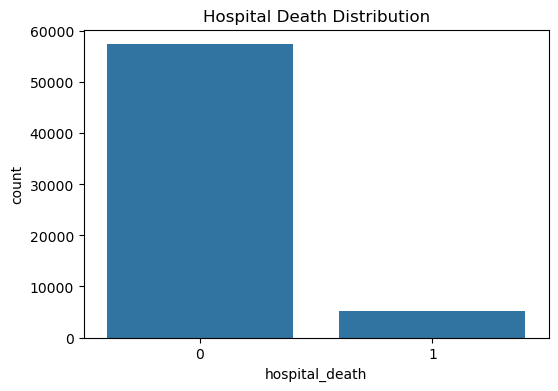

hospital_death
0    57396
1     5272
Name: count, dtype: int64

Percentage Distribution:
hospital_death
0    91.587413
1     8.412587
Name: proportion, dtype: float64


In [55]:

# Skewness of numerical features
skewness = data[numerical_features].apply(lambda x: skew(x.dropna()))
print("\nSkewness of Numerical Features:")
print(skewness)

# Plot distributions of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='hospital_death', data=data)
plt.title('Hospital Death Distribution')
plt.show()
print(data['hospital_death'].value_counts())
print("\nPercentage Distribution:")
print(data['hospital_death'].value_counts(normalize=True) * 100)

In [56]:
# what to do with missing values
# problem if missing data is not random, then data will be skewed 

# keep correlated varibales? 

# i need to scale for almost anything not tree? (numeric values) 

# use PCA to only choose a subset of the blood pressure features (look at scree plot) 

# are there any models where I should not use SMOTE?
# if the truth becomes 50 - 50
# try without smote first 
# think about where the threshold should be 

# create an invasive variable if data is diff
# deal with all this blood stuff

# captum shap values
# LIME is outdated 
# benchmark against existing scores

# vif is only for linear!!

In [57]:
for col in data.columns:
    print(col)

age
bmi
elective_surgery
height
pre_icu_los_days
weight
apache_2_diagnosis
apache_3j_diagnosis
apache_post_operative
arf_apache
gcs_eyes_apache
gcs_motor_apache
gcs_unable_apache
gcs_verbal_apache
heart_rate_apache
intubated_apache
map_apache
resprate_apache
temp_apache
ventilated_apache
d1_diasbp_max
d1_diasbp_min
d1_heartrate_max
d1_heartrate_min
d1_mbp_max
d1_mbp_min
d1_resprate_max
d1_resprate_min
d1_spo2_max
d1_spo2_min
d1_sysbp_max
d1_sysbp_min
d1_temp_max
d1_temp_min
d1_glucose_max
d1_glucose_min
d1_potassium_max
d1_potassium_min
aids
cirrhosis
diabetes_mellitus
hepatic_failure
immunosuppression
leukemia
lymphoma
solid_tumor_with_metastasis
hospital_death
icu_admit_source_Floor
icu_admit_source_Operating Room / Recovery
icu_admit_source_Other Hospital
icu_admit_source_Other ICU
ethnicity_Asian
ethnicity_Caucasian
ethnicity_Hispanic
ethnicity_Native American
ethnicity_Other/Unknown
gender_M
icu_type_CSICU
icu_type_CTICU
icu_type_Cardiac ICU
icu_type_MICU
icu_type_Med-Surg ICU
icu

In [58]:
categorical_columns = data.select_dtypes(include=['object']).columns

print("Categorical Columns in the Dataset:")
for col in categorical_columns:
    print(col)

Categorical Columns in the Dataset:


In [59]:
binary_categorical_columns = [col for col in data.columns if data[col].nunique() == 2 and sorted(data[col].unique()) == [0, 1]]

print("Binary Categorical Columns (0 and 1 values only):")
for col in binary_categorical_columns:
    print(col)

Binary Categorical Columns (0 and 1 values only):
elective_surgery
apache_post_operative
arf_apache
intubated_apache
ventilated_apache
aids
cirrhosis
diabetes_mellitus
hepatic_failure
immunosuppression
leukemia
lymphoma
solid_tumor_with_metastasis
hospital_death
icu_admit_source_Floor
icu_admit_source_Operating Room / Recovery
icu_admit_source_Other Hospital
icu_admit_source_Other ICU
ethnicity_Asian
ethnicity_Caucasian
ethnicity_Hispanic
ethnicity_Native American
ethnicity_Other/Unknown
gender_M
icu_type_CSICU
icu_type_CTICU
icu_type_Cardiac ICU
icu_type_MICU
icu_type_Med-Surg ICU
icu_type_Neuro ICU
icu_type_SICU
apache_3j_bodysystem_Gastrointestinal
apache_3j_bodysystem_Genitourinary
apache_3j_bodysystem_Gynecological
apache_3j_bodysystem_Hematological
apache_3j_bodysystem_Metabolic
apache_3j_bodysystem_Musculoskeletal/Skin
apache_3j_bodysystem_Neurological
apache_3j_bodysystem_Respiratory
apache_3j_bodysystem_Sepsis
apache_3j_bodysystem_Trauma
apache_2_bodysystem_Gastrointestinal
ap

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTENC


np.random.seed(18)
random.seed(18)


# Separate features and target variable
X = data.drop('hospital_death', axis=1)
y = data['hospital_death']

# --- 1. Split the Data into Training and Test Sets ---
# Use stratified sampling to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 2. Identify Numerical and Categorical Features ---
# Assuming binary categorical variables are not one-hot encoded
binary_categorical_features = [
    'elective_surgery', 'apache_post_operative', 'arf_apache', 'intubated_apache',
    'ventilated_apache', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
    'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis'
]

# Identify categorical features (including binary categorical features)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
for col in binary_categorical_features:
    if col not in categorical_features:
        categorical_features.append(col)

# Identify numerical features
numerical_features = [col for col in X_train.columns if col not in categorical_features]

# --- 3. Impute Missing Values ---

# Impute numerical features with median
numerical_imputer = SimpleImputer(strategy='median')
X_train[numerical_features] = numerical_imputer.fit_transform(X_train[numerical_features])
X_test[numerical_features] = numerical_imputer.transform(X_test[numerical_features])

# Impute categorical features with most frequent value
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[categorical_features] = categorical_imputer.fit_transform(X_train[categorical_features])
X_test[categorical_features] = categorical_imputer.transform(X_test[categorical_features])

# --- 4. Encode Categorical Features ---

# For binary categorical features (already 0/1), ensure they are integer type
for col in binary_categorical_features:
    X_train[col] = X_train[col].astype(int)
    X_test[col] = X_test[col].astype(int)

# For other categorical features, use Label Encoding
le = LabelEncoder()
non_binary_categorical_features = [col for col in categorical_features if col not in binary_categorical_features]
for col in non_binary_categorical_features:
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

# --- 5. Create Copies for Each Scenario ---

# a. No Scaling, No SMOTE
X_train_ns_ns = X_train.copy()
X_test_ns_ns = X_test.copy()
y_train_ns_ns = y_train.copy()
y_test_ns_ns = y_test.copy()

# b. Scaling, No SMOTE
X_train_s_ns = X_train.copy()
X_test_s_ns = X_test.copy()
y_train_s_ns = y_train.copy()
y_test_s_ns = y_test.copy()

# c. No Scaling, SMOTENC
X_train_ns_s = X_train.copy()
X_test_ns_s = X_test.copy()
y_train_ns_s = y_train.copy()
y_test_ns_s = y_test.copy()

# d. Scaling, SMOTENC
X_train_s_s = X_train.copy()
X_test_s_s = X_test.copy()
y_train_s_s = y_train.copy()
y_test_s_s = y_test.copy()

# --- 6. Apply Scaling Where Appropriate ---

# a. Scaling, No SMOTE
scaler_s_ns = StandardScaler()
X_train_s_ns[numerical_features] = scaler_s_ns.fit_transform(X_train_s_ns[numerical_features])
X_test_s_ns[numerical_features] = scaler_s_ns.transform(X_test_s_ns[numerical_features])

# b. Scaling, SMOTENC
scaler_s_s = StandardScaler()
X_train_s_s[numerical_features] = scaler_s_s.fit_transform(X_train_s_s[numerical_features])
X_test_s_s[numerical_features] = scaler_s_s.transform(X_test_s_s[numerical_features])

# --- 7. Apply SMOTE Where Appropriate ---

# Get categorical feature indices
categorical_indices_ns_s = [X_train_ns_s.columns.get_loc(col) for col in categorical_features]
categorical_indices_s_s = [X_train_s_s.columns.get_loc(col) for col in categorical_features]

# a. No Scaling, SMOTENC
smotenc_ns_s = SMOTENC(categorical_features=categorical_indices_ns_s, random_state=42)
X_train_ns_s, y_train_ns_s = smotenc_ns_s.fit_resample(X_train_ns_s, y_train_ns_s)

# b. Scaling, SMOTENC
smotenc_s_s = SMOTENC(categorical_features=categorical_indices_s_s, random_state=42)
X_train_s_s, y_train_s_s = smotenc_s_s.fit_resample(X_train_s_s, y_train_s_s)

# --- 8. Verify No Missing Values After SMOTENC ---
def check_missing_values(X, dataset_name):
    missing_values = X.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print(f"Missing values in {dataset_name}:")
        print(missing_values)
    else:
        print(f"No missing values in {dataset_name}.")

check_missing_values(X_train_ns_ns, "X_train_ns_ns")
check_missing_values(X_train_s_ns, "X_train_s_ns")
check_missing_values(X_train_ns_s, "X_train_ns_s")
check_missing_values(X_train_s_s, "X_train_s_s")

# --- 9. Print Class Distributions ---
def print_class_distribution(y, dataset_name):
    print(f"\nClass distribution in {dataset_name}:")
    print(y.value_counts(normalize=True) * 100)

print_class_distribution(y_train_ns_ns, "y_train_ns_ns (No Scaling, No SMOTE)")
print_class_distribution(y_train_s_ns, "y_train_s_ns (Scaling, No SMOTE)")
print_class_distribution(y_train_ns_s, "y_train_ns_s (No Scaling, SMOTENC)")
print_class_distribution(y_train_s_s, "y_train_s_s (Scaling, SMOTENC)")

# --- 10. Datasets Ready for Modeling ---
print("\nDatasets ready for modeling:")
print("1. X_train_ns_ns, y_train_ns_ns (No Scaling, No SMOTE)")
print("2. X_test_ns_ns, y_test_ns_ns")
print("3. X_train_s_ns, y_train_s_ns (Scaling, No SMOTE)")
print("4. X_test_s_ns, y_test_s_ns")
print("5. X_train_ns_s, y_train_ns_s (No Scaling, SMOTENC)")
print("6. X_test_ns_s, y_test_ns_s")
print("7. X_train_s_s, y_train_s_s (Scaling, SMOTENC)")
print("8. X_test_s_s, y_test_s_s")


No missing values in X_train_ns_ns.
No missing values in X_train_s_ns.
No missing values in X_train_ns_s.
No missing values in X_train_s_s.

Class distribution in y_train_ns_ns (No Scaling, No SMOTE):
hospital_death
0    91.586548
1     8.413452
Name: proportion, dtype: float64

Class distribution in y_train_s_ns (Scaling, No SMOTE):
hospital_death
0    91.586548
1     8.413452
Name: proportion, dtype: float64

Class distribution in y_train_ns_s (No Scaling, SMOTENC):
hospital_death
0    50.0
1    50.0
Name: proportion, dtype: float64

Class distribution in y_train_s_s (Scaling, SMOTENC):
hospital_death
0    50.0
1    50.0
Name: proportion, dtype: float64

Datasets ready for modeling:
1. X_train_ns_ns, y_train_ns_ns (No Scaling, No SMOTE)
2. X_test_ns_ns, y_test_ns_ns
3. X_train_s_ns, y_train_s_ns (Scaling, No SMOTE)
4. X_test_s_ns, y_test_s_ns
5. X_train_ns_s, y_train_ns_s (No Scaling, SMOTENC)
6. X_test_ns_s, y_test_ns_s
7. X_train_s_s, y_train_s_s (Scaling, SMOTENC)
8. X_test_s_s, y

### Log reg 

In [61]:
# --- Logistic Regression Without SMOTENC and Threshold Adjusting ---

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# --- 1. Train the Logistic Regression Model ---
# Using scaled data without SMOTE
model_lr_ns = LogisticRegression(max_iter=1000, random_state=42)
model_lr_ns.fit(X_train_s_ns, y_train_s_ns)

# --- 2. Predict on the Test Set ---
# Predict probabilities
y_pred_proba_ns = model_lr_ns.predict_proba(X_test_s_ns)[:, 1]

# Predict classes with default threshold 0.5
y_pred_ns = model_lr_ns.predict(X_test_s_ns)

# --- 3. Evaluate the Model ---
print("=== Logistic Regression Without SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_ns, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_ns))

roc_auc_ns = roc_auc_score(y_test_s_ns, y_pred_proba_ns)
print(f"ROC AUC Score: {roc_auc_ns:.4f}")



=== Logistic Regression Without SMOTENC ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9309    0.9887    0.9589     11480
           1     0.6199    0.2011    0.3037      1054

    accuracy                         0.9225     12534
   macro avg     0.7754    0.5949    0.6313     12534
weighted avg     0.9048    0.9225    0.9038     12534

Confusion Matrix:
[[11350   130]
 [  842   212]]
ROC AUC Score: 0.8574


### LOG REG WITH SMOTE

In [62]:
# --- Logistic Regression With SMOTENC and Threshold Adjusting ---

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

# --- 1. Train the Logistic Regression Model ---
# Using scaled data with SMOTENC
model_lr_s = LogisticRegression(max_iter=1000, random_state=42)
model_lr_s.fit(X_train_s_s, y_train_s_s)

# --- 2. Predict on the Test Set ---
# Predict probabilities
y_pred_proba_s = model_lr_s.predict_proba(X_test_s_s)[:, 1]

# Predict classes with default threshold 0.5
y_pred_s = model_lr_s.predict(X_test_s_s)

# --- 3. Evaluate the Model ---
print("\n=== Logistic Regression With SMOTENC ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_s, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_s))

roc_auc_s = roc_auc_score(y_test_s_s, y_pred_proba_s)
print(f"ROC AUC Score: {roc_auc_s:.4f}")




=== Logistic Regression With SMOTENC ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9641    0.8228    0.8879     11480
           1     0.2566    0.6660    0.3704      1054

    accuracy                         0.8096     12534
   macro avg     0.6103    0.7444    0.6292     12534
weighted avg     0.9046    0.8096    0.8444     12534

Confusion Matrix:
[[9446 2034]
 [ 352  702]]
ROC AUC Score: 0.8285


### Logistic Regression Without SMOTENC Using class_weight

=== Logistic Regression Without SMOTENC (Using class_weight='balanced') ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9727    0.7828    0.8675     11480
           1     0.2434    0.7609    0.3688      1054

    accuracy                         0.7810     12534
   macro avg     0.6081    0.7719    0.6182     12534
weighted avg     0.9114    0.7810    0.8256     12534

Confusion Matrix:
[[8987 2493]
 [ 252  802]]
ROC AUC Score: 0.8584


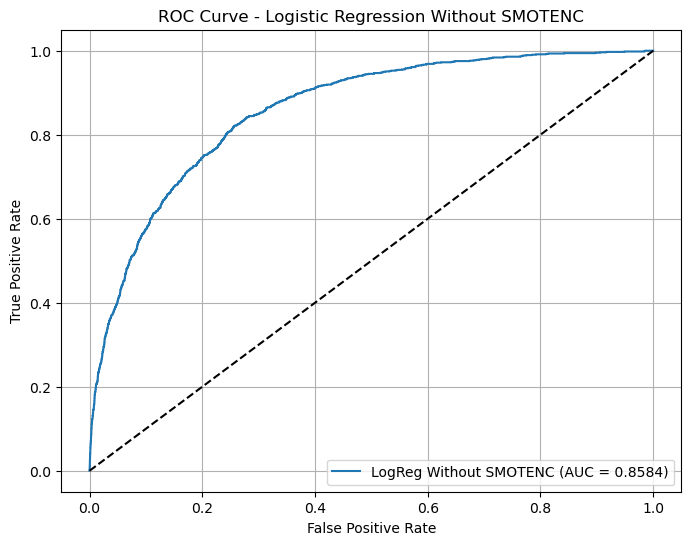

In [63]:
# --- Logistic Regression Without SMOTENC and Using Class Weights ---

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt

# --- 1. Initialize Logistic Regression Model ---
# Using class_weight='balanced' to handle class imbalance
model_lr_ns = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Automatically adjusts weights inversely proportional to class frequencies
)

# --- 2. Train the Model ---
model_lr_ns.fit(X_train_s_ns, y_train_s_ns)

# --- 3. Predict on the Test Set ---
# Predict probabilities
y_pred_proba_ns = model_lr_ns.predict_proba(X_test_s_ns)[:, 1]

# Predict classes with default threshold 0.5
y_pred_ns = model_lr_ns.predict(X_test_s_ns)

# --- 4. Evaluate the Model ---
print("=== Logistic Regression Without SMOTENC (Using class_weight='balanced') ===")
print("Classification Report:")
print(classification_report(y_test_s_ns, y_pred_ns, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test_s_ns, y_pred_ns))

roc_auc_ns = roc_auc_score(y_test_s_ns, y_pred_proba_ns)
print(f"ROC AUC Score: {roc_auc_ns:.4f}")

# --- 5. Plot ROC Curve ---
from sklearn.metrics import roc_curve

fpr_ns, tpr_ns, thresholds_ns = roc_curve(y_test_s_ns, y_pred_proba_ns)
plt.figure(figsize=(8, 6))
plt.plot(fpr_ns, tpr_ns, label=f'LogReg Without SMOTENC (AUC = {roc_auc_ns:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Without SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


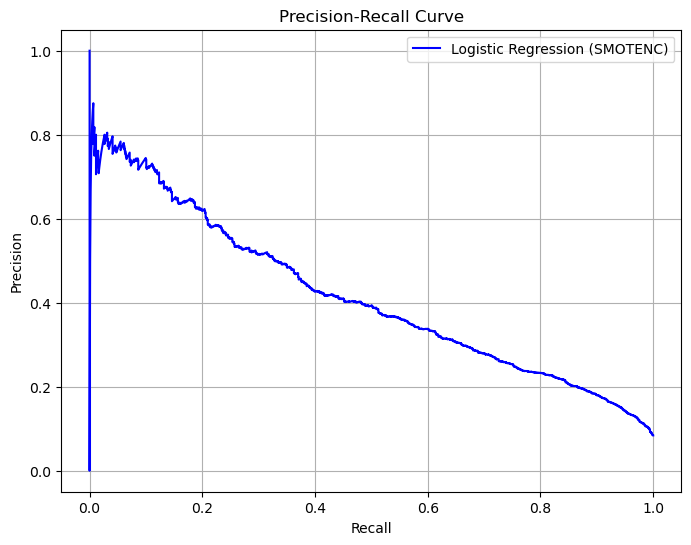

In [64]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Plot the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_s_ns, y_pred_proba_ns)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Logistic Regression (SMOTENC)', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### Logistic Regression With SMOTENC Using class_weight


=== Logistic Regression With SMOTENC (Using class_weight='balanced') ===
Classification Report:
              precision    recall  f1-score   support

           0     0.9641    0.8228    0.8879     11480
           1     0.2566    0.6660    0.3704      1054

    accuracy                         0.8096     12534
   macro avg     0.6103    0.7444    0.6292     12534
weighted avg     0.9046    0.8096    0.8444     12534

Confusion Matrix:
[[9446 2034]
 [ 352  702]]
ROC AUC Score: 0.8285


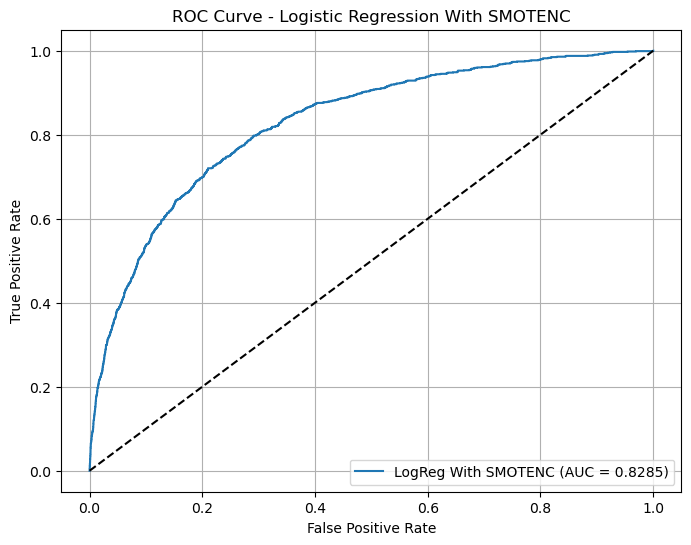

In [65]:
# --- Logistic Regression With SMOTENC and Using Class Weights ---

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# --- 1. Initialize Logistic Regression Model ---
# Using class_weight='balanced' to handle class imbalance
model_lr_s = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Automatically adjusts weights inversely proportional to class frequencies
)

# --- 2. Train the Model ---
model_lr_s.fit(X_train_s_s, y_train_s_s)

# --- 3. Predict on the Test Set ---
# Predict probabilities
y_pred_proba_s = model_lr_s.predict_proba(X_test_s_s)[:, 1]

# Predict classes with default threshold 0.5
y_pred_s = model_lr_s.predict(X_test_s_s)

# --- 4. Evaluate the Model ---
print("\n=== Logistic Regression With SMOTENC (Using class_weight='balanced') ===")
print("Classification Report:")
print(classification_report(y_test_s_s, y_pred_s, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_test_s_s, y_pred_s))

roc_auc_s = roc_auc_score(y_test_s_s, y_pred_proba_s)
print(f"ROC AUC Score: {roc_auc_s:.4f}")

# --- 5. Plot ROC Curve ---
from sklearn.metrics import roc_curve

fpr_s, tpr_s, thresholds_s = roc_curve(y_test_s_s, y_pred_proba_s)
plt.figure(figsize=(8, 6))
plt.plot(fpr_s, tpr_s, label=f'LogReg With SMOTENC (AUC = {roc_auc_s:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression With SMOTENC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


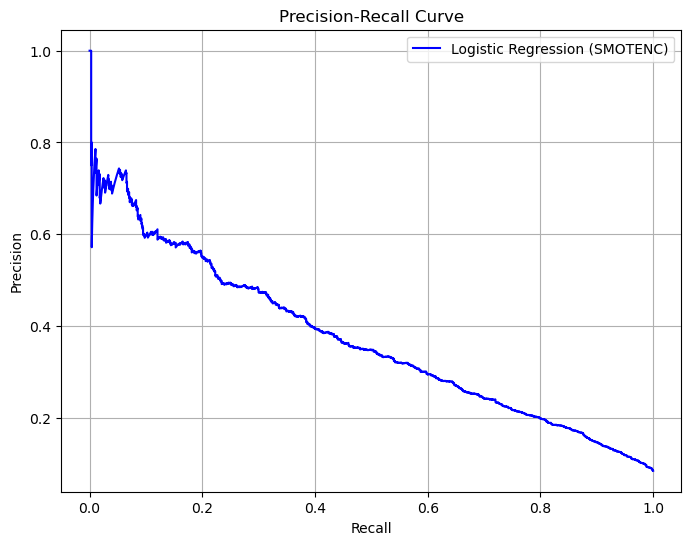

In [66]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Plot the Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test_s_s, y_pred_proba_s)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Logistic Regression (SMOTENC)', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()